In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import os

# Define learning parameters

In [ ]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 102340464.21it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 120174299.43it/s]


Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24961439.80it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22518355.52it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# GAN modules - Generator Discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, final_linear = False):
        super(Discriminator, self).__init__()
        self.n_input = 784
        layers = [
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        ]
        if final_linear:
            layers.pop()
        self.main = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

# Tools for training

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

# Common training loop function

In [ ]:
torch.manual_seed(7777)

def test_gan(tag, discriminator_loss, generator_loss, enableGANHacks=False, isWasserstein = False, epochs=epochs, k=k, nz=nz, gen_image_epochs=[1, 50, 100]):
    os.makedirs(f"outputs/{tag}", exist_ok=True)

    generator = Generator(nz).to(device)
    discriminator = Discriminator(final_linear=isWasserstein).to(device)

    # create the noise vector - fixed to track how GAN is trained.
    fixed_noise = create_noise(sample_size, nz)
    # optimizers
    optim_g = optim.Adam(generator.parameters(), lr=0.0002)
    optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)
    # loss function

    losses_g = []  # to store generator loss after each epoch
    losses_d = []  # to store discriminator loss after each epoch
    images = []  # to store images generatd by the generator

    for epoch in range(epochs):
        loss_g = 0.0
        loss_d = 0.0
        for bi, data in tqdm(
            enumerate(train_loader),
            total=int(len(train_data) / train_loader.batch_size),
        ):
            ############ YOUR CODE HERE ##########

            real_images, _ = data
            m = real_images.size(0)  # minibatch size
            real_images = real_images.to(device)
            real_labels = label_real(m)

            # Training the discriminator
            for _ in range(k):
                optim_d.zero_grad()

                # Real data
                output_real = discriminator(real_images)
                loss_real = discriminator_loss(output_real, real_labels, completion_ratio=(epoch+1)/epochs) if enableGANHacks else  discriminator_loss(output_real, real_labels)

                # Fake data
                fake_images = generator(create_noise(m, nz)).detach()  # Detach to avoid backpropagation through the generator
                fake_labels = label_fake(m)
                output_fake = discriminator(fake_images)
                loss_fake = discriminator_loss(output_fake, fake_labels, completion_ratio=(epoch+1)/epochs) if enableGANHacks else  discriminator_loss(output_fake, fake_labels)

                # Total discriminator loss
                loss_d_total = loss_real + loss_fake
                loss_d_total.backward()
                optim_d.step()
                loss_d += loss_d_total.item()

            if isWasserstein:
                # Clip discriminator weights (in Wasserstein GAN)
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

            # Training the generator
            optim_g.zero_grad()

            # Generate fake images
            generated_images = generator(create_noise(m, nz))
            output_generator = discriminator(generated_images)
            labels_generator = label_real(m)  # Generator wants the discriminator to think generated images are real
            loss_g_total = generator_loss(output_generator, labels_generator)

            # Total generator loss
            loss_g_total.backward()
            optim_g.step()
            loss_g += loss_g_total.item()
            ######################################

        # create the final fake image for the epoch
        generated_img = generator(fixed_noise).cpu().detach()

        # make the images as grid
        generated_img = make_grid(generated_img)

        # visualize generated images
        if (epoch + 1) in gen_image_epochs:
            plt.imshow(generated_img.permute(1, 2, 0))
            plt.title(f"epoch {epoch+1}")
            plt.axis("off")
            plt.show()

        # save the generated torch tensor models to disk
        save_generator_image(generated_img, f"outputs/{tag}/gen_img{epoch+1}.png")
        images.append(generated_img)
        epoch_loss_g = loss_g / bi  # total generator loss for the epoch
        epoch_loss_d = loss_d / bi  # total discriminator loss for the epoch
        losses_g.append(epoch_loss_g)
        losses_d.append(epoch_loss_d)

        print(f"Epoch {epoch+1} of {epochs}")
        print(
            f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}"
        )

    print("DONE TRAINING")
    torch.save(generator.state_dict(), f"outputs/{tag}/generator.pth")

    # save the generated images as GIF file
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave(f"outputs/{tag}/generator_images.gif", imgs)

    # plot and save the generator and discriminator loss
    plt.figure()
    plt.plot(losses_g, label="Generator loss")
    plt.plot(losses_d, label="Discriminator Loss")
    plt.legend()
    plt.savefig(f"outputs/{tag}/loss.png")
    plt.show()


118it [00:23,  4.98it/s]


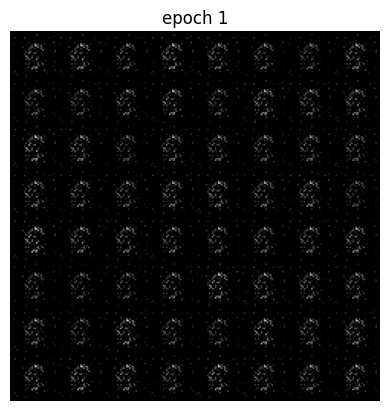

Epoch 1 of 200
Generator loss: 1.60993435, Discriminator loss: 0.86708001


118it [00:15,  7.59it/s]                         


Epoch 2 of 200
Generator loss: 2.76450660, Discriminator loss: 1.22260659


118it [00:15,  7.61it/s]                         


Epoch 3 of 200
Generator loss: 5.65848504, Discriminator loss: 0.60152498


118it [00:24,  4.79it/s]                         


Epoch 4 of 200
Generator loss: 2.19196312, Discriminator loss: 1.18552285


118it [00:15,  7.59it/s]                         


Epoch 5 of 200
Generator loss: 2.24902387, Discriminator loss: 1.04421370


118it [00:15,  7.67it/s]                         


Epoch 6 of 200
Generator loss: 1.37121430, Discriminator loss: 0.97483499


118it [00:16,  7.35it/s]                         


Epoch 7 of 200
Generator loss: 1.36198454, Discriminator loss: 1.15114174


118it [00:15,  7.49it/s]                         


Epoch 8 of 200
Generator loss: 2.38686090, Discriminator loss: 0.92396630


118it [00:15,  7.60it/s]                         


Epoch 9 of 200
Generator loss: 1.38407848, Discriminator loss: 1.06817797


118it [00:15,  7.69it/s]                         


Epoch 10 of 200
Generator loss: 1.17970574, Discriminator loss: 1.13221032


118it [00:15,  7.46it/s]                         


Epoch 11 of 200
Generator loss: 1.97429276, Discriminator loss: 0.73816316


118it [00:18,  6.24it/s]                         


Epoch 12 of 200
Generator loss: 2.57010489, Discriminator loss: 0.85051882


118it [00:15,  7.67it/s]                         


Epoch 13 of 200
Generator loss: 2.57184371, Discriminator loss: 0.58122499


118it [00:15,  7.68it/s]                         


Epoch 14 of 200
Generator loss: 3.14953981, Discriminator loss: 0.56797280


118it [00:15,  7.65it/s]                         


Epoch 15 of 200
Generator loss: 4.33333124, Discriminator loss: 0.45592610


118it [00:15,  7.64it/s]                         


Epoch 16 of 200
Generator loss: 3.19169066, Discriminator loss: 0.71091043


118it [00:15,  7.75it/s]                         


Epoch 17 of 200
Generator loss: 3.31435340, Discriminator loss: 0.49798822


118it [00:15,  7.75it/s]                         


Epoch 18 of 200
Generator loss: 3.32530680, Discriminator loss: 0.51795817


118it [00:15,  7.51it/s]                         


Epoch 19 of 200
Generator loss: 4.15382581, Discriminator loss: 0.36726708


118it [00:15,  7.41it/s]                         


Epoch 20 of 200
Generator loss: 3.95562096, Discriminator loss: 0.41684485


118it [00:15,  7.61it/s]                         


Epoch 21 of 200
Generator loss: 3.69989109, Discriminator loss: 0.46463683


118it [00:15,  7.79it/s]                         


Epoch 22 of 200
Generator loss: 3.56780159, Discriminator loss: 0.40970219


118it [00:15,  7.83it/s]                         


Epoch 23 of 200
Generator loss: 3.86048096, Discriminator loss: 0.49965093


118it [00:15,  7.80it/s]                         


Epoch 24 of 200
Generator loss: 3.25651822, Discriminator loss: 0.58436411


118it [00:15,  7.67it/s]                         


Epoch 25 of 200
Generator loss: 3.36535904, Discriminator loss: 0.41635616


118it [00:15,  7.70it/s]                         


Epoch 26 of 200
Generator loss: 3.76924898, Discriminator loss: 0.34575547


118it [00:15,  7.79it/s]                         


Epoch 27 of 200
Generator loss: 3.60969344, Discriminator loss: 0.45178400


118it [00:15,  7.81it/s]                         


Epoch 28 of 200
Generator loss: 3.44678962, Discriminator loss: 0.47675582


118it [00:15,  7.80it/s]                         


Epoch 29 of 200
Generator loss: 3.68685323, Discriminator loss: 0.44955452


118it [00:15,  7.62it/s]                         


Epoch 30 of 200
Generator loss: 3.79784929, Discriminator loss: 0.37318783


118it [00:15,  7.61it/s]                         


Epoch 31 of 200
Generator loss: 3.58460972, Discriminator loss: 0.54757331


118it [00:15,  7.62it/s]                         


Epoch 32 of 200
Generator loss: 3.27031939, Discriminator loss: 0.59132724


118it [00:15,  7.78it/s]                         


Epoch 33 of 200
Generator loss: 3.42538584, Discriminator loss: 0.47155592


118it [00:14,  7.97it/s]                         


Epoch 34 of 200
Generator loss: 3.15996271, Discriminator loss: 0.51223650


118it [00:14,  7.87it/s]                         


Epoch 35 of 200
Generator loss: 3.64773698, Discriminator loss: 0.40117690


118it [00:14,  7.93it/s]                         


Epoch 36 of 200
Generator loss: 3.58144749, Discriminator loss: 0.40142814


118it [00:15,  7.78it/s]                         


Epoch 37 of 200
Generator loss: 3.54702837, Discriminator loss: 0.44199661


118it [00:15,  7.86it/s]                         


Epoch 38 of 200
Generator loss: 3.50230873, Discriminator loss: 0.40094211


118it [00:15,  7.72it/s]                         


Epoch 39 of 200
Generator loss: 3.65464792, Discriminator loss: 0.42300378


118it [00:15,  7.78it/s]                         


Epoch 40 of 200
Generator loss: 3.20252121, Discriminator loss: 0.47508771


118it [00:15,  7.62it/s]                         


Epoch 41 of 200
Generator loss: 3.29322134, Discriminator loss: 0.42165161


118it [00:15,  7.60it/s]                         


Epoch 42 of 200
Generator loss: 3.53026283, Discriminator loss: 0.44341899


118it [00:15,  7.78it/s]                         


Epoch 43 of 200
Generator loss: 3.62223499, Discriminator loss: 0.39538492


118it [00:15,  7.84it/s]                         


Epoch 44 of 200
Generator loss: 3.21360987, Discriminator loss: 0.45543775


118it [00:14,  7.90it/s]                         


Epoch 45 of 200
Generator loss: 2.94217773, Discriminator loss: 0.50891868


118it [00:15,  7.79it/s]                         


Epoch 46 of 200
Generator loss: 3.22905287, Discriminator loss: 0.42040248


118it [00:15,  7.86it/s]                         


Epoch 47 of 200
Generator loss: 3.32178515, Discriminator loss: 0.43417564


118it [00:14,  7.91it/s]                         


Epoch 48 of 200
Generator loss: 3.15128413, Discriminator loss: 0.49211570


118it [00:15,  7.81it/s]                         


Epoch 49 of 200
Generator loss: 3.04477551, Discriminator loss: 0.54404848


118it [00:14,  7.92it/s]                         


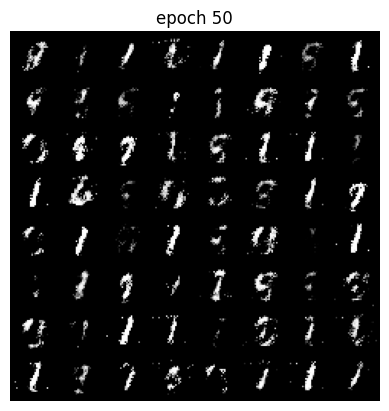

Epoch 50 of 200
Generator loss: 3.26409337, Discriminator loss: 0.50722014


118it [00:15,  7.74it/s]                         


Epoch 51 of 200
Generator loss: 2.99070504, Discriminator loss: 0.52386128


118it [00:15,  7.68it/s]                         


Epoch 52 of 200
Generator loss: 3.14198497, Discriminator loss: 0.46769060


118it [00:15,  7.38it/s]                         


Epoch 53 of 200
Generator loss: 3.08290624, Discriminator loss: 0.44184241


118it [00:15,  7.76it/s]                         


Epoch 54 of 200
Generator loss: 3.14350203, Discriminator loss: 0.44149085


118it [00:15,  7.81it/s]                         


Epoch 55 of 200
Generator loss: 3.01562161, Discriminator loss: 0.49191733


118it [00:15,  7.79it/s]                         


Epoch 56 of 200
Generator loss: 2.96817318, Discriminator loss: 0.52072212


118it [00:15,  7.73it/s]                         


Epoch 57 of 200
Generator loss: 2.99899000, Discriminator loss: 0.49686695


118it [00:15,  7.80it/s]                         


Epoch 58 of 200
Generator loss: 3.03173327, Discriminator loss: 0.48546927


118it [00:15,  7.83it/s]                         


Epoch 59 of 200
Generator loss: 3.02481952, Discriminator loss: 0.45795756


118it [00:15,  7.79it/s]                         


Epoch 60 of 200
Generator loss: 3.02843569, Discriminator loss: 0.47532628


118it [00:15,  7.75it/s]                         


Epoch 61 of 200
Generator loss: 2.73425380, Discriminator loss: 0.53076787


118it [00:15,  7.62it/s]                         


Epoch 62 of 200
Generator loss: 2.73220302, Discriminator loss: 0.50705809


118it [00:15,  7.56it/s]                         


Epoch 63 of 200
Generator loss: 2.70825630, Discriminator loss: 0.52874724


118it [00:15,  7.66it/s]                         


Epoch 64 of 200
Generator loss: 2.58128968, Discriminator loss: 0.54707851


118it [00:15,  7.69it/s]                         


Epoch 65 of 200
Generator loss: 2.80017256, Discriminator loss: 0.51059026


118it [00:15,  7.81it/s]                         


Epoch 66 of 200
Generator loss: 2.71355542, Discriminator loss: 0.57399102


118it [00:15,  7.79it/s]                         


Epoch 67 of 200
Generator loss: 2.49266433, Discriminator loss: 0.60120144


118it [00:14,  7.92it/s]                         


Epoch 68 of 200
Generator loss: 2.60335296, Discriminator loss: 0.56219307


118it [00:15,  7.83it/s]                         


Epoch 69 of 200
Generator loss: 2.86764213, Discriminator loss: 0.54878441


118it [00:15,  7.73it/s]                         


Epoch 70 of 200
Generator loss: 2.70347735, Discriminator loss: 0.57491571


118it [00:15,  7.86it/s]                         


Epoch 71 of 200
Generator loss: 2.43011266, Discriminator loss: 0.60278569


118it [00:15,  7.84it/s]                         


Epoch 72 of 200
Generator loss: 2.59096901, Discriminator loss: 0.56349971


118it [00:15,  7.75it/s]                         


Epoch 73 of 200
Generator loss: 2.44330819, Discriminator loss: 0.62566672


118it [00:15,  7.53it/s]                         


Epoch 74 of 200
Generator loss: 2.49649617, Discriminator loss: 0.61312388


118it [00:15,  7.67it/s]                         


Epoch 75 of 200
Generator loss: 2.58134326, Discriminator loss: 0.59377188


118it [00:14,  7.89it/s]                         


Epoch 76 of 200
Generator loss: 2.51981371, Discriminator loss: 0.64462147


118it [00:14,  7.87it/s]                         


Epoch 77 of 200
Generator loss: 2.50373537, Discriminator loss: 0.61845967


118it [00:14,  7.92it/s]                         


Epoch 78 of 200
Generator loss: 2.62220458, Discriminator loss: 0.58107392


118it [00:14,  7.87it/s]                         


Epoch 79 of 200
Generator loss: 2.64441327, Discriminator loss: 0.56058772


118it [00:15,  7.81it/s]                         


Epoch 80 of 200
Generator loss: 2.56868656, Discriminator loss: 0.60401852


118it [00:15,  7.77it/s]                         


Epoch 81 of 200
Generator loss: 2.33063886, Discriminator loss: 0.63160460


118it [00:15,  7.84it/s]                         


Epoch 82 of 200
Generator loss: 2.29600599, Discriminator loss: 0.64637121


118it [00:14,  7.89it/s]                         


Epoch 83 of 200
Generator loss: 2.38201946, Discriminator loss: 0.63967182


118it [00:15,  7.74it/s]                         


Epoch 84 of 200
Generator loss: 2.28961218, Discriminator loss: 0.67809911


118it [00:15,  7.60it/s]                         


Epoch 85 of 200
Generator loss: 2.11894485, Discriminator loss: 0.70862079


118it [00:15,  7.64it/s]                         


Epoch 86 of 200
Generator loss: 2.26851350, Discriminator loss: 0.71773120


118it [00:15,  7.78it/s]                         


Epoch 87 of 200
Generator loss: 2.22240252, Discriminator loss: 0.73507090


118it [00:15,  7.86it/s]                         


Epoch 88 of 200
Generator loss: 2.25986953, Discriminator loss: 0.66350065


118it [00:15,  7.80it/s]                         


Epoch 89 of 200
Generator loss: 2.18864615, Discriminator loss: 0.69328344


118it [00:15,  7.75it/s]                         


Epoch 90 of 200
Generator loss: 2.16894757, Discriminator loss: 0.72238857


118it [00:14,  7.87it/s]                         


Epoch 91 of 200
Generator loss: 2.23457285, Discriminator loss: 0.70386108


118it [00:15,  7.83it/s]                         


Epoch 92 of 200
Generator loss: 2.11453151, Discriminator loss: 0.73902642


118it [00:15,  7.85it/s]                         


Epoch 93 of 200
Generator loss: 2.18885828, Discriminator loss: 0.69911014


118it [00:15,  7.79it/s]                         


Epoch 94 of 200
Generator loss: 2.20042844, Discriminator loss: 0.70803710


118it [00:15,  7.81it/s]                         


Epoch 95 of 200
Generator loss: 2.18623123, Discriminator loss: 0.72949887


118it [00:15,  7.57it/s]                         


Epoch 96 of 200
Generator loss: 2.18578816, Discriminator loss: 0.70934358


118it [00:15,  7.71it/s]                         


Epoch 97 of 200
Generator loss: 2.13680955, Discriminator loss: 0.74996563


118it [00:15,  7.70it/s]                         


Epoch 98 of 200
Generator loss: 2.03852690, Discriminator loss: 0.74762624


118it [00:14,  7.92it/s]                         


Epoch 99 of 200
Generator loss: 2.01939054, Discriminator loss: 0.77922215


118it [00:15,  7.85it/s]                         


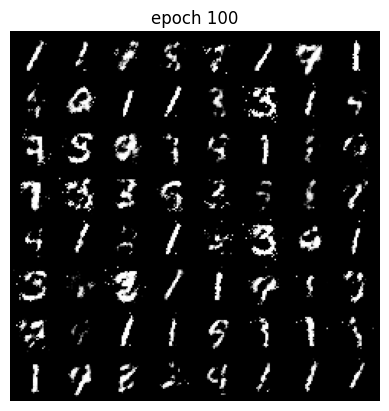

Epoch 100 of 200
Generator loss: 1.98841526, Discriminator loss: 0.78281677


118it [00:15,  7.68it/s]                         


Epoch 101 of 200
Generator loss: 2.00873778, Discriminator loss: 0.78047019


118it [00:15,  7.73it/s]                         


Epoch 102 of 200
Generator loss: 1.97792640, Discriminator loss: 0.83868777


118it [00:15,  7.76it/s]                         


Epoch 103 of 200
Generator loss: 1.95293662, Discriminator loss: 0.78077189


118it [00:15,  7.83it/s]                         


Epoch 104 of 200
Generator loss: 1.98523513, Discriminator loss: 0.77488866


118it [00:15,  7.77it/s]                         


Epoch 105 of 200
Generator loss: 1.97630741, Discriminator loss: 0.77868000


118it [00:15,  7.52it/s]                         


Epoch 106 of 200
Generator loss: 1.89285460, Discriminator loss: 0.80748935


118it [00:15,  7.52it/s]                         


Epoch 107 of 200
Generator loss: 1.93145828, Discriminator loss: 0.81832305


118it [00:15,  7.66it/s]                         


Epoch 108 of 200
Generator loss: 1.86091543, Discriminator loss: 0.82606714


118it [00:15,  7.73it/s]                         


Epoch 109 of 200
Generator loss: 2.01222290, Discriminator loss: 0.77686324


118it [00:15,  7.67it/s]                         


Epoch 110 of 200
Generator loss: 1.85916661, Discriminator loss: 0.83869993


118it [00:15,  7.79it/s]                         


Epoch 111 of 200
Generator loss: 1.91952597, Discriminator loss: 0.80981268


118it [00:15,  7.85it/s]                         


Epoch 112 of 200
Generator loss: 1.87503616, Discriminator loss: 0.82014312


118it [00:15,  7.76it/s]                         


Epoch 113 of 200
Generator loss: 1.88900689, Discriminator loss: 0.83912410


118it [00:15,  7.82it/s]                         


Epoch 114 of 200
Generator loss: 1.87153223, Discriminator loss: 0.81401848


118it [00:15,  7.79it/s]                         


Epoch 115 of 200
Generator loss: 1.91508250, Discriminator loss: 0.83363783


118it [00:15,  7.76it/s]                         


Epoch 116 of 200
Generator loss: 1.90047380, Discriminator loss: 0.83059076


118it [00:15,  7.48it/s]                         


Epoch 117 of 200
Generator loss: 1.80144112, Discriminator loss: 0.83479127


118it [00:15,  7.63it/s]                         


Epoch 118 of 200
Generator loss: 1.82193221, Discriminator loss: 0.82787751


118it [00:15,  7.82it/s]                         


Epoch 119 of 200
Generator loss: 1.83634474, Discriminator loss: 0.85982580


118it [00:15,  7.76it/s]                         


Epoch 120 of 200
Generator loss: 1.78438134, Discriminator loss: 0.86815491


118it [00:15,  7.75it/s]                         


Epoch 121 of 200
Generator loss: 1.74496514, Discriminator loss: 0.85932924


118it [00:15,  7.72it/s]                         


Epoch 122 of 200
Generator loss: 1.80153120, Discriminator loss: 0.86268686


118it [00:15,  7.70it/s]                         


Epoch 123 of 200
Generator loss: 1.65411501, Discriminator loss: 0.94100310


118it [00:15,  7.76it/s]                         


Epoch 124 of 200
Generator loss: 1.55954609, Discriminator loss: 0.95272986


118it [00:15,  7.67it/s]                         


Epoch 125 of 200
Generator loss: 1.67800522, Discriminator loss: 0.89852072


118it [00:15,  7.74it/s]                         


Epoch 126 of 200
Generator loss: 1.65222321, Discriminator loss: 0.91478882


118it [00:15,  7.60it/s]                         


Epoch 127 of 200
Generator loss: 1.70238297, Discriminator loss: 0.91122103


118it [00:15,  7.59it/s]                         


Epoch 128 of 200
Generator loss: 1.66697728, Discriminator loss: 0.91412682


118it [00:15,  7.68it/s]                         


Epoch 129 of 200
Generator loss: 1.65543687, Discriminator loss: 0.93164203


118it [00:15,  7.79it/s]                         


Epoch 130 of 200
Generator loss: 1.67497078, Discriminator loss: 0.91079946


118it [00:15,  7.72it/s]                         


Epoch 131 of 200
Generator loss: 1.56848475, Discriminator loss: 0.95554350


118it [00:15,  7.81it/s]                         


Epoch 132 of 200
Generator loss: 1.60711561, Discriminator loss: 0.94799569


118it [00:15,  7.79it/s]                         


Epoch 133 of 200
Generator loss: 1.60939244, Discriminator loss: 0.93707271


118it [00:15,  7.65it/s]                         


Epoch 134 of 200
Generator loss: 1.56767443, Discriminator loss: 0.94410531


118it [00:15,  7.69it/s]                         


Epoch 135 of 200
Generator loss: 1.57445758, Discriminator loss: 0.95516828


118it [00:15,  7.81it/s]                         


Epoch 136 of 200
Generator loss: 1.58155677, Discriminator loss: 0.93394690


118it [00:15,  7.58it/s]                         


Epoch 137 of 200
Generator loss: 1.55410245, Discriminator loss: 0.97062493


118it [00:15,  7.53it/s]                         


Epoch 138 of 200
Generator loss: 1.58996695, Discriminator loss: 0.94668026


118it [00:15,  7.79it/s]                         


Epoch 139 of 200
Generator loss: 1.55719597, Discriminator loss: 0.94874484


118it [00:15,  7.86it/s]                         


Epoch 140 of 200
Generator loss: 1.54970690, Discriminator loss: 0.96893209


118it [00:15,  7.75it/s]                         


Epoch 141 of 200
Generator loss: 1.55272823, Discriminator loss: 0.95274852


118it [00:15,  7.77it/s]                         


Epoch 142 of 200
Generator loss: 1.58010996, Discriminator loss: 0.94410151


118it [00:15,  7.67it/s]                         


Epoch 143 of 200
Generator loss: 1.56550228, Discriminator loss: 0.97320092


118it [00:15,  7.72it/s]                         


Epoch 144 of 200
Generator loss: 1.55800101, Discriminator loss: 0.97545725


118it [00:15,  7.73it/s]                         


Epoch 145 of 200
Generator loss: 1.49820855, Discriminator loss: 0.98624713


118it [00:15,  7.79it/s]                         


Epoch 146 of 200
Generator loss: 1.52813898, Discriminator loss: 0.96989846


118it [00:15,  7.47it/s]                         


Epoch 147 of 200
Generator loss: 1.52924685, Discriminator loss: 0.98026194


118it [00:15,  7.52it/s]                         


Epoch 148 of 200
Generator loss: 1.54992079, Discriminator loss: 0.98716871


118it [00:15,  7.73it/s]                         


Epoch 149 of 200
Generator loss: 1.64144560, Discriminator loss: 0.95481839


118it [00:15,  7.77it/s]                         


Epoch 150 of 200
Generator loss: 1.53682179, Discriminator loss: 0.96308022


118it [00:15,  7.73it/s]                         


Epoch 151 of 200
Generator loss: 1.55106593, Discriminator loss: 0.96654632


118it [00:15,  7.68it/s]                         


Epoch 152 of 200
Generator loss: 1.57749155, Discriminator loss: 0.95234215


118it [00:15,  7.76it/s]                         


Epoch 153 of 200
Generator loss: 1.52293467, Discriminator loss: 0.97090194


118it [00:15,  7.64it/s]                         


Epoch 154 of 200
Generator loss: 1.56581713, Discriminator loss: 0.97201353


118it [00:15,  7.70it/s]                         


Epoch 155 of 200
Generator loss: 1.49918767, Discriminator loss: 0.97036774


118it [00:15,  7.63it/s]                         


Epoch 156 of 200
Generator loss: 1.57345603, Discriminator loss: 0.97094471


118it [00:15,  7.53it/s]                         


Epoch 157 of 200
Generator loss: 1.53333985, Discriminator loss: 0.96699050


118it [00:15,  7.54it/s]                         


Epoch 158 of 200
Generator loss: 1.53777401, Discriminator loss: 0.96766971


118it [00:15,  7.66it/s]                         


Epoch 159 of 200
Generator loss: 1.53560287, Discriminator loss: 0.97295010


118it [00:15,  7.75it/s]                         


Epoch 160 of 200
Generator loss: 1.46903265, Discriminator loss: 0.99509144


118it [00:15,  7.72it/s]                         


Epoch 161 of 200
Generator loss: 1.43662545, Discriminator loss: 1.00684951


118it [00:15,  7.71it/s]                         


Epoch 162 of 200
Generator loss: 1.47098486, Discriminator loss: 1.00407067


118it [00:15,  7.72it/s]                         


Epoch 163 of 200
Generator loss: 1.41938259, Discriminator loss: 1.01250271


118it [00:15,  7.66it/s]                         


Epoch 164 of 200
Generator loss: 1.44850911, Discriminator loss: 1.00683077


118it [00:15,  7.69it/s]                         


Epoch 165 of 200
Generator loss: 1.43987120, Discriminator loss: 0.99242490


118it [00:15,  7.51it/s]                         


Epoch 166 of 200
Generator loss: 1.43342247, Discriminator loss: 1.01934144


118it [00:15,  7.44it/s]                         


Epoch 167 of 200
Generator loss: 1.45827606, Discriminator loss: 1.00276653


118it [00:15,  7.49it/s]                         


Epoch 168 of 200
Generator loss: 1.41137491, Discriminator loss: 1.04166004


118it [00:15,  7.58it/s]                         


Epoch 169 of 200
Generator loss: 1.43236342, Discriminator loss: 1.01750637


118it [00:15,  7.55it/s]                         


Epoch 170 of 200
Generator loss: 1.44620115, Discriminator loss: 1.00598684


118it [00:15,  7.56it/s]                         


Epoch 171 of 200
Generator loss: 1.37756705, Discriminator loss: 1.03481795


118it [00:15,  7.68it/s]                         


Epoch 172 of 200
Generator loss: 1.44803339, Discriminator loss: 1.01836301


118it [00:15,  7.64it/s]                         


Epoch 173 of 200
Generator loss: 1.46490767, Discriminator loss: 0.99820530


118it [00:15,  7.47it/s]                         


Epoch 174 of 200
Generator loss: 1.37742526, Discriminator loss: 1.04326174


118it [00:16,  7.35it/s]                         


Epoch 175 of 200
Generator loss: 1.39889189, Discriminator loss: 1.03548969


118it [00:16,  7.37it/s]                         


Epoch 176 of 200
Generator loss: 1.42389389, Discriminator loss: 1.03167897


118it [00:15,  7.64it/s]                         


Epoch 177 of 200
Generator loss: 1.39137783, Discriminator loss: 1.03991631


118it [00:15,  7.61it/s]                         


Epoch 178 of 200
Generator loss: 1.35855598, Discriminator loss: 1.04048345


118it [00:15,  7.60it/s]                         


Epoch 179 of 200
Generator loss: 1.43255280, Discriminator loss: 1.01896874


118it [00:15,  7.57it/s]                         


Epoch 180 of 200
Generator loss: 1.40802547, Discriminator loss: 1.03963165


118it [00:15,  7.50it/s]                         


Epoch 181 of 200
Generator loss: 1.41317708, Discriminator loss: 1.03990451


118it [00:15,  7.65it/s]                         


Epoch 182 of 200
Generator loss: 1.34056889, Discriminator loss: 1.04319731


118it [00:15,  7.49it/s]                         


Epoch 183 of 200
Generator loss: 1.38690215, Discriminator loss: 1.04066984


118it [00:16,  7.36it/s]                         


Epoch 184 of 200
Generator loss: 1.37791069, Discriminator loss: 1.05193314


118it [00:15,  7.50it/s]                         


Epoch 185 of 200
Generator loss: 1.35745675, Discriminator loss: 1.04532374


118it [00:15,  7.70it/s]                         


Epoch 186 of 200
Generator loss: 1.39541566, Discriminator loss: 1.03414238


118it [00:15,  7.61it/s]                         


Epoch 187 of 200
Generator loss: 1.34272897, Discriminator loss: 1.04608958


118it [00:15,  7.54it/s]                         


Epoch 188 of 200
Generator loss: 1.33140225, Discriminator loss: 1.06921009


118it [00:15,  7.69it/s]                         


Epoch 189 of 200
Generator loss: 1.31511059, Discriminator loss: 1.06046584


118it [00:15,  7.63it/s]                         


Epoch 190 of 200
Generator loss: 1.30789215, Discriminator loss: 1.06567478


118it [00:15,  7.59it/s]                         


Epoch 191 of 200
Generator loss: 1.30970800, Discriminator loss: 1.07114147


118it [00:15,  7.50it/s]                         


Epoch 192 of 200
Generator loss: 1.28393795, Discriminator loss: 1.09219025


118it [00:15,  7.56it/s]                         


Epoch 193 of 200
Generator loss: 1.25987582, Discriminator loss: 1.09011345


118it [00:15,  7.82it/s]                         


Epoch 194 of 200
Generator loss: 1.33640651, Discriminator loss: 1.05745789


118it [00:15,  7.84it/s]                         


Epoch 195 of 200
Generator loss: 1.34838198, Discriminator loss: 1.05099831


118it [00:14,  7.89it/s]                         


Epoch 196 of 200
Generator loss: 1.35187302, Discriminator loss: 1.06189603


118it [00:14,  7.93it/s]                         


Epoch 197 of 200
Generator loss: 1.28235149, Discriminator loss: 1.08048199


118it [00:14,  8.16it/s]                         


Epoch 198 of 200
Generator loss: 1.31842764, Discriminator loss: 1.07698790


118it [00:14,  8.15it/s]                         


Epoch 199 of 200
Generator loss: 1.33024496, Discriminator loss: 1.07278057


118it [00:14,  7.99it/s]                         


Epoch 200 of 200
Generator loss: 1.32957322, Discriminator loss: 1.06866136
DONE TRAINING


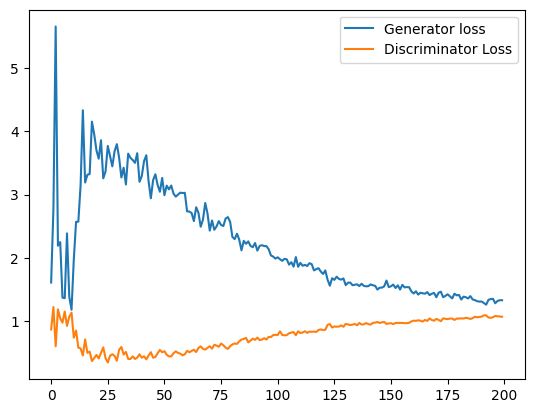

In [ ]:
# Question 1a:
# Non-saturating GAN Loss

def gen_loss_a(output, true_label):
    criterion = nn.BCELoss() # Binary Cross Entropy loss
    return criterion(output, true_label)

def dis_loss_a(output, true_label):
    criterion = nn.BCELoss() # Binary Cross Entropy loss
    return criterion(output, true_label)

test_gan('1a', discriminator_loss=dis_loss_a, generator_loss=gen_loss_a)

118it [00:14,  7.99it/s]                         


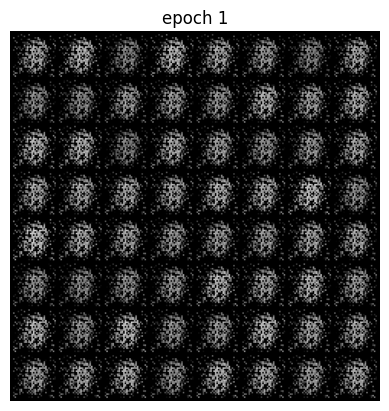

Epoch 1 of 20
Generator loss: -0.23800032, Discriminator loss: 0.44604534


118it [00:15,  7.80it/s]                         


Epoch 2 of 20
Generator loss: -0.01250715, Discriminator loss: 0.07786564


118it [00:15,  7.48it/s]                         


Epoch 3 of 20
Generator loss: -0.00000001, Discriminator loss: 0.00004787


118it [00:18,  6.48it/s]                         


Epoch 4 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000579


118it [00:17,  6.56it/s]                         


Epoch 5 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000487


118it [00:16,  7.07it/s]                         


Epoch 6 of 20
Generator loss: -0.00000001, Discriminator loss: 0.00000417


118it [00:14,  7.91it/s]                         


Epoch 7 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000300


118it [00:15,  7.53it/s]                         


Epoch 8 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000268


118it [00:15,  7.61it/s]                         


Epoch 9 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000214


118it [00:15,  7.54it/s]                         


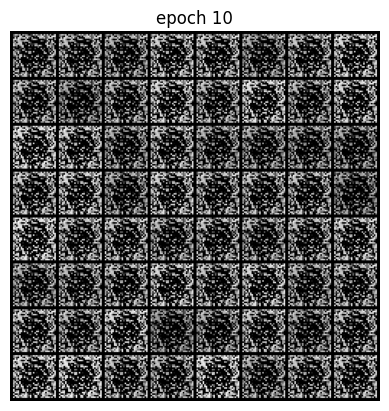

Epoch 10 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000175


118it [00:15,  7.79it/s]                         


Epoch 11 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000157


118it [00:15,  7.83it/s]                         


Epoch 12 of 20
Generator loss: -0.00000001, Discriminator loss: 0.00000137


118it [00:15,  7.73it/s]                         


Epoch 13 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000128


118it [00:15,  7.76it/s]                         


Epoch 14 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000107


118it [00:15,  7.80it/s]                         


Epoch 15 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000096


118it [00:15,  7.86it/s]                         


Epoch 16 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000088


118it [00:16,  7.25it/s]                         


Epoch 17 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000075


118it [00:15,  7.68it/s]                         


Epoch 18 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000069


118it [00:15,  7.60it/s]                         


Epoch 19 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000064


118it [00:15,  7.85it/s]                         


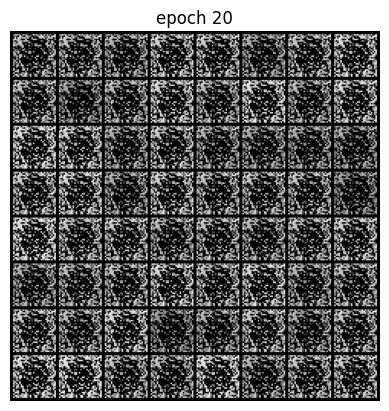

Epoch 20 of 20
Generator loss: -0.00000000, Discriminator loss: 0.00000057
DONE TRAINING


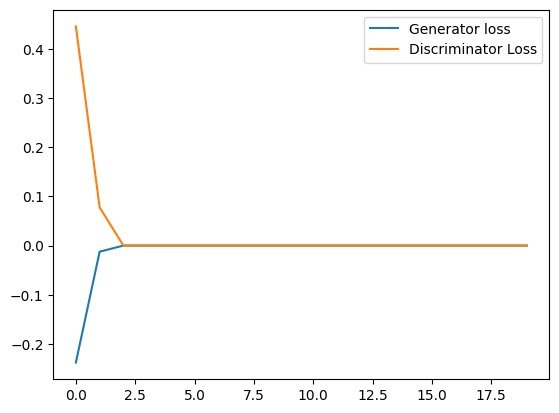

In [ ]:
# Question 1b:
# Minimax GAN Loss - naive implementation

def gen_loss_b(output, true_label):
    criterion = nn.BCELoss() # Binary Cross Entropy loss
    return -criterion(1 - output, true_label)

def dis_loss_b(output, true_label):
    criterion = nn.BCELoss() # Binary Cross Entropy loss
    return criterion(output, true_label)

test_gan('1b', discriminator_loss=dis_loss_b, generator_loss=gen_loss_b, epochs=20, gen_image_epochs=[1, 10, 20])

118it [00:15,  7.83it/s]                         


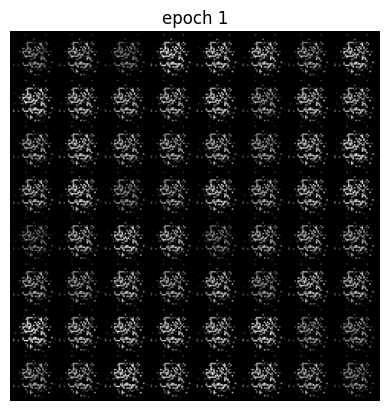

Epoch 1 of 200
Generator loss: -0.28772461, Discriminator loss: 0.91431989


118it [00:15,  7.52it/s]                         


Epoch 2 of 200
Generator loss: -0.14148373, Discriminator loss: 0.84847636


118it [00:15,  7.39it/s]                         


Epoch 3 of 200
Generator loss: -0.36997460, Discriminator loss: 1.05667768


118it [00:15,  7.78it/s]                         


Epoch 4 of 200
Generator loss: -0.11461420, Discriminator loss: 0.66649280


118it [00:15,  7.58it/s]                         


Epoch 5 of 200
Generator loss: -0.23816256, Discriminator loss: 0.81664617


118it [00:15,  7.62it/s]                         


Epoch 6 of 200
Generator loss: -0.24719859, Discriminator loss: 0.86128001


118it [00:15,  7.55it/s]                         


Epoch 7 of 200
Generator loss: -0.23977527, Discriminator loss: 0.82481066


118it [00:15,  7.81it/s]                         


Epoch 8 of 200
Generator loss: -0.30043610, Discriminator loss: 0.96496496


118it [00:15,  7.47it/s]                         


Epoch 9 of 200
Generator loss: -0.37248650, Discriminator loss: 1.04436418


118it [00:15,  7.77it/s]                         


Epoch 10 of 200
Generator loss: -0.27797001, Discriminator loss: 0.88988267


118it [00:15,  7.78it/s]                         


Epoch 11 of 200
Generator loss: -0.32408732, Discriminator loss: 1.00745747


118it [00:15,  7.86it/s]                         


Epoch 12 of 200
Generator loss: -0.27223983, Discriminator loss: 0.91304004


118it [00:15,  7.79it/s]                         


Epoch 13 of 200
Generator loss: -0.29342013, Discriminator loss: 0.95634616


118it [00:15,  7.81it/s]                         


Epoch 14 of 200
Generator loss: -0.32128412, Discriminator loss: 0.95230047


118it [00:15,  7.72it/s]                         


Epoch 15 of 200
Generator loss: -0.32237154, Discriminator loss: 0.96374439


118it [00:15,  7.72it/s]                         


Epoch 16 of 200
Generator loss: -0.30477142, Discriminator loss: 0.97903039


118it [00:15,  7.61it/s]                         


Epoch 17 of 200
Generator loss: -0.37597140, Discriminator loss: 0.98841068


118it [00:14,  7.89it/s]                         


Epoch 18 of 200
Generator loss: -0.41155556, Discriminator loss: 1.04992797


118it [00:14,  7.96it/s]                         


Epoch 19 of 200
Generator loss: -0.23670460, Discriminator loss: 0.83368839


118it [00:14,  7.92it/s]                         


Epoch 20 of 200
Generator loss: -0.18067873, Discriminator loss: 0.77869600


118it [00:14,  7.97it/s]                         


Epoch 21 of 200
Generator loss: -0.18486746, Discriminator loss: 0.78225377


118it [00:15,  7.85it/s]                         


Epoch 22 of 200
Generator loss: -0.14948372, Discriminator loss: 0.71019352


118it [00:14,  7.90it/s]                         


Epoch 23 of 200
Generator loss: -0.14883034, Discriminator loss: 0.71630594


118it [00:15,  7.71it/s]                         


Epoch 24 of 200
Generator loss: -0.16510469, Discriminator loss: 0.72186763


118it [00:14,  7.88it/s]                         


Epoch 25 of 200
Generator loss: -0.15311483, Discriminator loss: 0.71953012


118it [00:15,  7.83it/s]                         


Epoch 26 of 200
Generator loss: -0.13630431, Discriminator loss: 0.68602960


118it [00:15,  7.78it/s]                         


Epoch 27 of 200
Generator loss: -0.13616458, Discriminator loss: 0.67662758


118it [00:15,  7.57it/s]                         


Epoch 28 of 200
Generator loss: -0.13882144, Discriminator loss: 0.68561901


118it [00:14,  7.90it/s]                         


Epoch 29 of 200
Generator loss: -0.12112671, Discriminator loss: 0.64243574


118it [00:15,  7.82it/s]                         


Epoch 30 of 200
Generator loss: -0.13553553, Discriminator loss: 0.66576715


118it [00:15,  7.86it/s]                         


Epoch 31 of 200
Generator loss: -0.12837105, Discriminator loss: 0.65519741


118it [00:14,  7.89it/s]                         


Epoch 32 of 200
Generator loss: -0.13239001, Discriminator loss: 0.65281875


118it [00:14,  7.94it/s]                         


Epoch 33 of 200
Generator loss: -0.13230524, Discriminator loss: 0.63271399


118it [00:15,  7.84it/s]                         


Epoch 34 of 200
Generator loss: -0.13605197, Discriminator loss: 0.63423613


118it [00:15,  7.84it/s]                         


Epoch 35 of 200
Generator loss: -0.14512776, Discriminator loss: 0.66276773


118it [00:15,  7.82it/s]                         


Epoch 36 of 200
Generator loss: -0.14554421, Discriminator loss: 0.66334693


118it [00:15,  7.70it/s]                         


Epoch 37 of 200
Generator loss: -0.13847340, Discriminator loss: 0.64005080


118it [00:15,  7.74it/s]                         


Epoch 38 of 200
Generator loss: -0.14032729, Discriminator loss: 0.63076795


118it [00:15,  7.62it/s]                         


Epoch 39 of 200
Generator loss: -0.14795168, Discriminator loss: 0.65151442


118it [00:14,  7.90it/s]                         


Epoch 40 of 200
Generator loss: -0.12995288, Discriminator loss: 0.61588103


118it [00:14,  7.93it/s]                         


Epoch 41 of 200
Generator loss: -0.16685135, Discriminator loss: 0.69991163


118it [00:15,  7.78it/s]                         


Epoch 42 of 200
Generator loss: -0.17279753, Discriminator loss: 0.68117951


118it [00:15,  7.79it/s]                         


Epoch 43 of 200
Generator loss: -0.19873621, Discriminator loss: 0.75284121


118it [00:15,  7.76it/s]                         


Epoch 44 of 200
Generator loss: -0.18325938, Discriminator loss: 0.69631903


118it [00:15,  7.78it/s]                         


Epoch 45 of 200
Generator loss: -0.17843075, Discriminator loss: 0.68334533


118it [00:15,  7.75it/s]                         


Epoch 46 of 200
Generator loss: -0.19107900, Discriminator loss: 0.70424513


118it [00:14,  7.99it/s]                         


Epoch 47 of 200
Generator loss: -0.17253055, Discriminator loss: 0.69032498


118it [00:15,  7.71it/s]                         


Epoch 48 of 200
Generator loss: -0.18171059, Discriminator loss: 0.68683919


118it [00:15,  7.71it/s]                         


Epoch 49 of 200
Generator loss: -0.19332526, Discriminator loss: 0.70925412


118it [00:14,  7.88it/s]                         


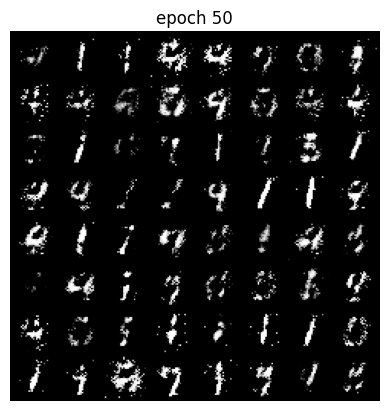

Epoch 50 of 200
Generator loss: -0.19984094, Discriminator loss: 0.71612370


118it [00:15,  7.79it/s]                         


Epoch 51 of 200
Generator loss: -0.22160438, Discriminator loss: 0.75885780


118it [00:15,  7.39it/s]                         


Epoch 52 of 200
Generator loss: -0.22477885, Discriminator loss: 0.75359814


118it [00:15,  7.54it/s]                         


Epoch 53 of 200
Generator loss: -0.24115600, Discriminator loss: 0.75739585


118it [00:15,  7.56it/s]                         


Epoch 54 of 200
Generator loss: -0.23358414, Discriminator loss: 0.75980100


118it [00:15,  7.78it/s]                         


Epoch 55 of 200
Generator loss: -0.24943697, Discriminator loss: 0.80057167


118it [00:15,  7.70it/s]                         


Epoch 56 of 200
Generator loss: -0.26015863, Discriminator loss: 0.79283320


118it [00:15,  7.74it/s]                         


Epoch 57 of 200
Generator loss: -0.25435736, Discriminator loss: 0.79612451


118it [00:15,  7.59it/s]                         


Epoch 58 of 200
Generator loss: -0.23264573, Discriminator loss: 0.73358546


118it [00:15,  7.52it/s]                         


Epoch 59 of 200
Generator loss: -0.25693966, Discriminator loss: 0.77582837


118it [00:15,  7.51it/s]                         


Epoch 60 of 200
Generator loss: -0.26575413, Discriminator loss: 0.79985587


118it [00:15,  7.59it/s]                         


Epoch 61 of 200
Generator loss: -0.23692408, Discriminator loss: 0.74541642


118it [00:15,  7.69it/s]                         


Epoch 62 of 200
Generator loss: -0.23182224, Discriminator loss: 0.72420064


118it [00:15,  7.67it/s]                         


Epoch 63 of 200
Generator loss: -0.23592274, Discriminator loss: 0.72557559


118it [00:15,  7.60it/s]                         


Epoch 64 of 200
Generator loss: -0.26467549, Discriminator loss: 0.77926888


118it [00:15,  7.66it/s]                         


Epoch 65 of 200
Generator loss: -0.28084768, Discriminator loss: 0.80554070


118it [00:15,  7.56it/s]                         


Epoch 66 of 200
Generator loss: -0.29753435, Discriminator loss: 0.83035446


118it [00:16,  7.36it/s]                         


Epoch 67 of 200
Generator loss: -0.28414226, Discriminator loss: 0.79696952


118it [00:15,  7.43it/s]                         


Epoch 68 of 200
Generator loss: -0.26763437, Discriminator loss: 0.75842907


118it [00:15,  7.69it/s]                         


Epoch 69 of 200
Generator loss: -0.28427433, Discriminator loss: 0.78482825


118it [00:15,  7.80it/s]                         


Epoch 70 of 200
Generator loss: -0.31330755, Discriminator loss: 0.85963732


118it [00:15,  7.69it/s]                         


Epoch 71 of 200
Generator loss: -0.28448497, Discriminator loss: 0.79106204


118it [00:15,  7.74it/s]                         


Epoch 72 of 200
Generator loss: -0.24080956, Discriminator loss: 0.70333177


118it [00:15,  7.77it/s]                         


Epoch 73 of 200
Generator loss: -0.29805984, Discriminator loss: 0.80535117


118it [00:15,  7.56it/s]                         


Epoch 74 of 200
Generator loss: -0.31270276, Discriminator loss: 0.83383388


118it [00:15,  7.75it/s]                         


Epoch 75 of 200
Generator loss: -0.28096160, Discriminator loss: 0.74976780


118it [00:15,  7.55it/s]                         


Epoch 76 of 200
Generator loss: -0.31043951, Discriminator loss: 0.81199691


118it [00:15,  7.40it/s]                         


Epoch 77 of 200
Generator loss: -0.29247183, Discriminator loss: 0.78860718


118it [00:15,  7.55it/s]                         


Epoch 78 of 200
Generator loss: -0.31407391, Discriminator loss: 0.80944876


118it [00:15,  7.44it/s]                         


Epoch 79 of 200
Generator loss: -0.32088154, Discriminator loss: 0.81711040


118it [00:15,  7.61it/s]                         


Epoch 80 of 200
Generator loss: -0.31766822, Discriminator loss: 0.82883603


118it [00:15,  7.60it/s]                         


Epoch 81 of 200
Generator loss: -0.33607712, Discriminator loss: 0.84754918


118it [00:15,  7.76it/s]                         


Epoch 82 of 200
Generator loss: -0.33070229, Discriminator loss: 0.82350048


118it [00:15,  7.69it/s]                         


Epoch 83 of 200
Generator loss: -0.36149853, Discriminator loss: 0.88343332


118it [00:15,  7.52it/s]                         


Epoch 84 of 200
Generator loss: -0.31481202, Discriminator loss: 0.78789464


118it [00:15,  7.61it/s]                         


Epoch 85 of 200
Generator loss: -0.34450406, Discriminator loss: 0.83744634


118it [00:15,  7.56it/s]                         


Epoch 86 of 200
Generator loss: -0.33531403, Discriminator loss: 0.83327668


118it [00:15,  7.64it/s]                         


Epoch 87 of 200
Generator loss: -0.34534618, Discriminator loss: 0.85610199


118it [00:15,  7.57it/s]                         


Epoch 88 of 200
Generator loss: -0.35296882, Discriminator loss: 0.85236258


118it [00:15,  7.78it/s]                         


Epoch 89 of 200
Generator loss: -0.35033955, Discriminator loss: 0.83041795


118it [00:15,  7.80it/s]                         


Epoch 90 of 200
Generator loss: -0.35534804, Discriminator loss: 0.84048826


118it [00:15,  7.73it/s]                         


Epoch 91 of 200
Generator loss: -0.36925465, Discriminator loss: 0.86792311


118it [00:15,  7.75it/s]                         


Epoch 92 of 200
Generator loss: -0.35574158, Discriminator loss: 0.84179204


118it [00:15,  7.67it/s]                         


Epoch 93 of 200
Generator loss: -0.34688560, Discriminator loss: 0.81354406


118it [00:15,  7.43it/s]                         


Epoch 94 of 200
Generator loss: -0.34837610, Discriminator loss: 0.83168766


118it [00:15,  7.49it/s]                         


Epoch 95 of 200
Generator loss: -0.37058336, Discriminator loss: 0.85234242


118it [00:15,  7.74it/s]                         


Epoch 96 of 200
Generator loss: -0.37137704, Discriminator loss: 0.87096145


118it [00:14,  7.89it/s]                         


Epoch 97 of 200
Generator loss: -0.36357381, Discriminator loss: 0.85019789


118it [00:15,  7.76it/s]                         


Epoch 98 of 200
Generator loss: -0.37857447, Discriminator loss: 0.85698525


118it [00:15,  7.74it/s]                         


Epoch 99 of 200
Generator loss: -0.39718120, Discriminator loss: 0.90565409


118it [00:15,  7.73it/s]                         


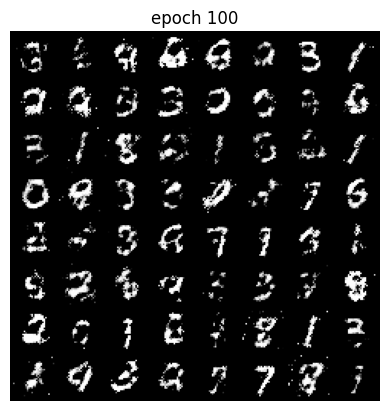

Epoch 100 of 200
Generator loss: -0.40302732, Discriminator loss: 0.91493017


118it [00:15,  7.75it/s]                         


Epoch 101 of 200
Generator loss: -0.38153812, Discriminator loss: 0.86931559


118it [00:15,  7.60it/s]                         


Epoch 102 of 200
Generator loss: -0.36626407, Discriminator loss: 0.82698163


118it [00:15,  7.48it/s]                         


Epoch 103 of 200
Generator loss: -0.38505151, Discriminator loss: 0.85930748


118it [00:15,  7.65it/s]                         


Epoch 104 of 200
Generator loss: -0.38118289, Discriminator loss: 0.84666892


118it [00:15,  7.68it/s]                         


Epoch 105 of 200
Generator loss: -0.35738792, Discriminator loss: 0.81232259


118it [00:15,  7.76it/s]                         


Epoch 106 of 200
Generator loss: -0.39012849, Discriminator loss: 0.86608317


118it [00:15,  7.60it/s]                         


Epoch 107 of 200
Generator loss: -0.39150980, Discriminator loss: 0.87153284


118it [00:15,  7.62it/s]                         


Epoch 108 of 200
Generator loss: -0.41948312, Discriminator loss: 0.93344525


118it [00:15,  7.66it/s]                         


Epoch 109 of 200
Generator loss: -0.39081752, Discriminator loss: 0.87696882


118it [00:15,  7.70it/s]                         


Epoch 110 of 200
Generator loss: -0.37090977, Discriminator loss: 0.83262893


118it [00:15,  7.49it/s]                         


Epoch 111 of 200
Generator loss: -0.38349808, Discriminator loss: 0.85356993


118it [00:15,  7.61it/s]                         


Epoch 112 of 200
Generator loss: -0.40449084, Discriminator loss: 0.88689623


118it [00:15,  7.60it/s]                         


Epoch 113 of 200
Generator loss: -0.39992399, Discriminator loss: 0.88536102


118it [00:15,  7.58it/s]                         


Epoch 114 of 200
Generator loss: -0.41199016, Discriminator loss: 0.90802451


118it [00:15,  7.77it/s]                         


Epoch 115 of 200
Generator loss: -0.42839973, Discriminator loss: 0.95059835


118it [00:15,  7.73it/s]                         


Epoch 116 of 200
Generator loss: -0.43087440, Discriminator loss: 0.95000318


118it [00:15,  7.69it/s]                         


Epoch 117 of 200
Generator loss: -0.47186592, Discriminator loss: 1.01093501


118it [00:15,  7.61it/s]                         


Epoch 118 of 200
Generator loss: -0.42974257, Discriminator loss: 0.94051532


118it [00:15,  7.63it/s]                         


Epoch 119 of 200
Generator loss: -0.44090304, Discriminator loss: 0.95358886


118it [00:15,  7.59it/s]                         


Epoch 120 of 200
Generator loss: -0.44977772, Discriminator loss: 0.98641581


118it [00:15,  7.73it/s]                         


Epoch 121 of 200
Generator loss: -0.41507749, Discriminator loss: 0.91548437


118it [00:16,  7.34it/s]                         


Epoch 122 of 200
Generator loss: -0.42689522, Discriminator loss: 0.94340420


118it [00:16,  7.36it/s]                         


Epoch 123 of 200
Generator loss: -0.43766759, Discriminator loss: 0.94561313


118it [00:15,  7.71it/s]                         


Epoch 124 of 200
Generator loss: -0.43708469, Discriminator loss: 0.95271652


118it [00:15,  7.61it/s]                         


Epoch 125 of 200
Generator loss: -0.43120687, Discriminator loss: 0.95136161


118it [00:15,  7.67it/s]                         


Epoch 126 of 200
Generator loss: -0.45962317, Discriminator loss: 0.98333688


118it [00:15,  7.75it/s]                         


Epoch 127 of 200
Generator loss: -0.44075335, Discriminator loss: 0.96212734


118it [00:15,  7.48it/s]                         


Epoch 128 of 200
Generator loss: -0.44769510, Discriminator loss: 0.96675510


118it [00:15,  7.57it/s]                         


Epoch 129 of 200
Generator loss: -0.45235491, Discriminator loss: 0.96834744


118it [00:15,  7.55it/s]                         


Epoch 130 of 200
Generator loss: -0.44048459, Discriminator loss: 0.94826978


118it [00:15,  7.44it/s]                         


Epoch 131 of 200
Generator loss: -0.45568244, Discriminator loss: 0.99631098


118it [00:15,  7.61it/s]                         


Epoch 132 of 200
Generator loss: -0.44792584, Discriminator loss: 0.97860232


118it [00:15,  7.70it/s]                         


Epoch 133 of 200
Generator loss: -0.46824292, Discriminator loss: 1.01161664


118it [00:15,  7.63it/s]                         


Epoch 134 of 200
Generator loss: -0.46155178, Discriminator loss: 0.99108741


118it [00:15,  7.69it/s]                         


Epoch 135 of 200
Generator loss: -0.44053924, Discriminator loss: 0.95790932


118it [00:15,  7.75it/s]                         


Epoch 136 of 200
Generator loss: -0.46658755, Discriminator loss: 1.00288298


118it [00:15,  7.61it/s]                         


Epoch 137 of 200
Generator loss: -0.46274252, Discriminator loss: 0.98694707


118it [00:15,  7.53it/s]                         


Epoch 138 of 200
Generator loss: -0.45356372, Discriminator loss: 0.97562890


118it [00:15,  7.68it/s]                         


Epoch 139 of 200
Generator loss: -0.47479338, Discriminator loss: 1.03383475


118it [00:15,  7.52it/s]                         


Epoch 140 of 200
Generator loss: -0.49356027, Discriminator loss: 1.05085830


118it [00:15,  7.40it/s]                         


Epoch 141 of 200
Generator loss: -0.48132021, Discriminator loss: 1.02214602


118it [00:15,  7.63it/s]                         


Epoch 142 of 200
Generator loss: -0.49821956, Discriminator loss: 1.06250494


118it [00:15,  7.76it/s]                         


Epoch 143 of 200
Generator loss: -0.48912720, Discriminator loss: 1.03110961


118it [00:15,  7.70it/s]                         


Epoch 144 of 200
Generator loss: -0.49765157, Discriminator loss: 1.05501025


118it [00:15,  7.58it/s]                         


Epoch 145 of 200
Generator loss: -0.47910813, Discriminator loss: 1.03213148


118it [00:15,  7.54it/s]                         


Epoch 146 of 200
Generator loss: -0.47170454, Discriminator loss: 1.01579284


118it [00:15,  7.73it/s]                         


Epoch 147 of 200
Generator loss: -0.49271387, Discriminator loss: 1.03616750


118it [00:15,  7.73it/s]                         


Epoch 148 of 200
Generator loss: -0.47062034, Discriminator loss: 1.01594040


118it [00:16,  7.24it/s]                         


Epoch 149 of 200
Generator loss: -0.48107831, Discriminator loss: 1.03507353


118it [00:16,  7.28it/s]                         


Epoch 150 of 200
Generator loss: -0.51393604, Discriminator loss: 1.08350048


118it [00:15,  7.60it/s]                         


Epoch 151 of 200
Generator loss: -0.51590807, Discriminator loss: 1.07645454


118it [00:15,  7.58it/s]                         


Epoch 152 of 200
Generator loss: -0.50138622, Discriminator loss: 1.06799594


118it [00:15,  7.38it/s]                         


Epoch 153 of 200
Generator loss: -0.51368297, Discriminator loss: 1.07908325


118it [00:15,  7.52it/s]                         


Epoch 154 of 200
Generator loss: -0.50449382, Discriminator loss: 1.05659334


118it [00:15,  7.63it/s]                         


Epoch 155 of 200
Generator loss: -0.51182398, Discriminator loss: 1.07323213


118it [00:15,  7.67it/s]                         


Epoch 156 of 200
Generator loss: -0.52960942, Discriminator loss: 1.11392239


118it [00:15,  7.42it/s]                         


Epoch 157 of 200
Generator loss: -0.50449561, Discriminator loss: 1.05942708


118it [00:15,  7.42it/s]                         


Epoch 158 of 200
Generator loss: -0.49322624, Discriminator loss: 1.03381353


118it [00:15,  7.50it/s]                         


Epoch 159 of 200
Generator loss: -0.52041868, Discriminator loss: 1.09881134


118it [00:15,  7.51it/s]                         


Epoch 160 of 200
Generator loss: -0.51129447, Discriminator loss: 1.07767944


118it [00:15,  7.57it/s]                         


Epoch 161 of 200
Generator loss: -0.49542549, Discriminator loss: 1.05013556


118it [00:15,  7.48it/s]                         


Epoch 162 of 200
Generator loss: -0.49416946, Discriminator loss: 1.03728314


118it [00:15,  7.53it/s]                         


Epoch 163 of 200
Generator loss: -0.50202088, Discriminator loss: 1.05951660


118it [00:16,  7.34it/s]                         


Epoch 164 of 200
Generator loss: -0.49513071, Discriminator loss: 1.05213291


118it [00:15,  7.38it/s]                         


Epoch 165 of 200
Generator loss: -0.50345664, Discriminator loss: 1.06013622


118it [00:16,  7.27it/s]                         


Epoch 166 of 200
Generator loss: -0.50430855, Discriminator loss: 1.06899842


118it [00:15,  7.56it/s]                         


Epoch 167 of 200
Generator loss: -0.49658214, Discriminator loss: 1.05722005


118it [00:15,  7.45it/s]                         


Epoch 168 of 200
Generator loss: -0.51503413, Discriminator loss: 1.07446579


118it [00:15,  7.57it/s]                         


Epoch 169 of 200
Generator loss: -0.51492062, Discriminator loss: 1.07695211


118it [00:15,  7.57it/s]                         


Epoch 170 of 200
Generator loss: -0.51386593, Discriminator loss: 1.09080161


118it [00:15,  7.64it/s]                         


Epoch 171 of 200
Generator loss: -0.52551700, Discriminator loss: 1.08671674


118it [00:15,  7.54it/s]                         


Epoch 172 of 200
Generator loss: -0.49941542, Discriminator loss: 1.07369240


118it [00:16,  7.32it/s]                         


Epoch 173 of 200
Generator loss: -0.51063294, Discriminator loss: 1.06021597


118it [00:15,  7.40it/s]                         


Epoch 174 of 200
Generator loss: -0.50831798, Discriminator loss: 1.08798468


118it [00:15,  7.57it/s]                         


Epoch 175 of 200
Generator loss: -0.53732553, Discriminator loss: 1.11226407


118it [00:15,  7.49it/s]                         


Epoch 176 of 200
Generator loss: -0.52153648, Discriminator loss: 1.09226905


118it [00:15,  7.65it/s]                         


Epoch 177 of 200
Generator loss: -0.52782308, Discriminator loss: 1.10237509


118it [00:15,  7.62it/s]                         


Epoch 178 of 200
Generator loss: -0.52561017, Discriminator loss: 1.09272306


118it [00:15,  7.58it/s]                         


Epoch 179 of 200
Generator loss: -0.50274876, Discriminator loss: 1.06293751


118it [00:15,  7.41it/s]                         


Epoch 180 of 200
Generator loss: -0.53116928, Discriminator loss: 1.10879277


118it [00:15,  7.54it/s]                         


Epoch 181 of 200
Generator loss: -0.52505646, Discriminator loss: 1.09551864


118it [00:16,  7.25it/s]                         


Epoch 182 of 200
Generator loss: -0.52317470, Discriminator loss: 1.09376303


118it [00:16,  7.26it/s]                         


Epoch 183 of 200
Generator loss: -0.52864089, Discriminator loss: 1.10378052


118it [00:15,  7.46it/s]                         


Epoch 184 of 200
Generator loss: -0.53766868, Discriminator loss: 1.12717167


118it [00:15,  7.57it/s]                         


Epoch 185 of 200
Generator loss: -0.54421857, Discriminator loss: 1.12861400


118it [00:15,  7.57it/s]                         


Epoch 186 of 200
Generator loss: -0.55459866, Discriminator loss: 1.14201078


118it [00:15,  7.38it/s]                         


Epoch 187 of 200
Generator loss: -0.54359729, Discriminator loss: 1.12196068


118it [00:15,  7.48it/s]                         


Epoch 188 of 200
Generator loss: -0.56120933, Discriminator loss: 1.14957434


118it [00:15,  7.58it/s]                         


Epoch 189 of 200
Generator loss: -0.54417156, Discriminator loss: 1.15628301


118it [00:15,  7.45it/s]                         


Epoch 190 of 200
Generator loss: -0.56494440, Discriminator loss: 1.15273953


118it [00:15,  7.41it/s]                         


Epoch 191 of 200
Generator loss: -0.55128932, Discriminator loss: 1.14217091


118it [00:15,  7.51it/s]                         


Epoch 192 of 200
Generator loss: -0.55770081, Discriminator loss: 1.13452228


118it [00:15,  7.58it/s]                         


Epoch 193 of 200
Generator loss: -0.55393431, Discriminator loss: 1.13990463


118it [00:15,  7.58it/s]                         


Epoch 194 of 200
Generator loss: -0.55121015, Discriminator loss: 1.14236722


118it [00:15,  7.58it/s]                         


Epoch 195 of 200
Generator loss: -0.56224266, Discriminator loss: 1.14769373


118it [00:15,  7.66it/s]                         


Epoch 196 of 200
Generator loss: -0.54866013, Discriminator loss: 1.14034204


118it [00:15,  7.71it/s]                         


Epoch 197 of 200
Generator loss: -0.55377423, Discriminator loss: 1.15120056


118it [00:15,  7.65it/s]                         


Epoch 198 of 200
Generator loss: -0.57721905, Discriminator loss: 1.16639595


118it [00:16,  7.29it/s]                         


Epoch 199 of 200
Generator loss: -0.57174848, Discriminator loss: 1.17969854


118it [00:16,  7.24it/s]                         


Epoch 200 of 200
Generator loss: -0.56041739, Discriminator loss: 1.15868584
DONE TRAINING


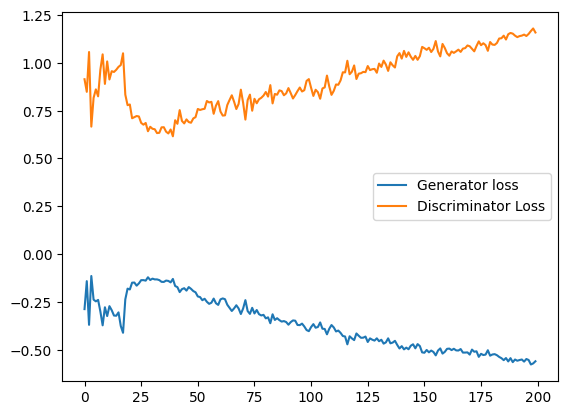

In [ ]:
# Question 1b:
# Minimax GAN Loss - modified

def gen_loss_b(output, true_label):
    criterion = nn.BCELoss() # Binary Cross Entropy loss
    return -criterion(1-output, true_label)

def dis_loss_b(output, true_label, completion_ratio):
    criterion = nn.BCELoss() # Binary Cross Entropy loss
    if completion_ratio < 0.5:
        smooth = torch.rand(true_label.size()).to(device)
        smooth = (1 - completion_ratio*2)*(0.2*smooth)
        true_label = true_label + (1-true_label)*smooth - true_label*smooth
    return criterion(output, true_label)

test_gan('1b', discriminator_loss=dis_loss_b, generator_loss=gen_loss_b, enableGANHacks=True)

118it [00:21,  5.46it/s]                         


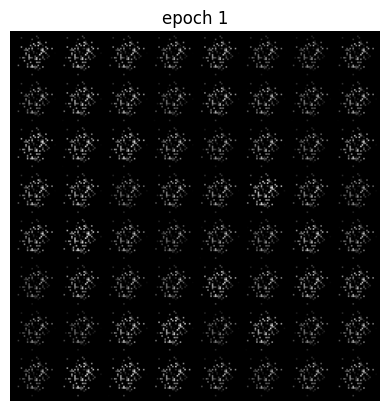

Epoch 1 of 200
Generator loss: 0.59082045, Discriminator loss: 0.22280459


118it [00:15,  7.84it/s]                         


Epoch 2 of 200
Generator loss: 0.95014132, Discriminator loss: 0.09625039


118it [00:15,  7.84it/s]                         


Epoch 3 of 200
Generator loss: 0.89121833, Discriminator loss: 0.16902795


118it [00:15,  7.72it/s]                         


Epoch 4 of 200
Generator loss: 0.80705066, Discriminator loss: 0.20979687


118it [00:15,  7.84it/s]                         


Epoch 5 of 200
Generator loss: 0.49059503, Discriminator loss: 0.51087551


118it [00:16,  7.26it/s]                         


Epoch 6 of 200
Generator loss: 0.94430342, Discriminator loss: 0.08374134


118it [00:15,  7.66it/s]                         


Epoch 7 of 200
Generator loss: 0.76358754, Discriminator loss: 0.20861173


118it [00:15,  7.67it/s]                         


Epoch 8 of 200
Generator loss: 0.73897944, Discriminator loss: 0.24193647


118it [00:15,  7.62it/s]                         


Epoch 9 of 200
Generator loss: 0.48934339, Discriminator loss: 0.41487661


118it [00:15,  7.70it/s]                         


Epoch 10 of 200
Generator loss: 0.59092517, Discriminator loss: 0.34786311


118it [00:15,  7.84it/s]                         


Epoch 11 of 200
Generator loss: 0.50959389, Discriminator loss: 0.37555987


118it [00:14,  7.88it/s]                         


Epoch 12 of 200
Generator loss: 0.41248829, Discriminator loss: 0.41462203


118it [00:15,  7.78it/s]                         


Epoch 13 of 200
Generator loss: 0.42241704, Discriminator loss: 0.46456545


118it [00:15,  7.78it/s]                         


Epoch 14 of 200
Generator loss: 0.42374276, Discriminator loss: 0.40775272


118it [00:15,  7.78it/s]                         


Epoch 15 of 200
Generator loss: 0.44750812, Discriminator loss: 0.42751205


118it [00:15,  7.62it/s]                         


Epoch 16 of 200
Generator loss: 0.50132721, Discriminator loss: 0.36380714


118it [00:15,  7.56it/s]                         


Epoch 17 of 200
Generator loss: 0.44578789, Discriminator loss: 0.44807563


118it [00:16,  7.33it/s]                         


Epoch 18 of 200
Generator loss: 0.62760227, Discriminator loss: 0.31781616


118it [00:15,  7.45it/s]                         


Epoch 19 of 200
Generator loss: 0.67696881, Discriminator loss: 0.27625385


118it [00:15,  7.73it/s]                         


Epoch 20 of 200
Generator loss: 0.74815805, Discriminator loss: 0.22896743


118it [00:15,  7.59it/s]                         


Epoch 21 of 200
Generator loss: 0.60387083, Discriminator loss: 0.34762757


118it [00:15,  7.71it/s]                         


Epoch 22 of 200
Generator loss: 0.65768299, Discriminator loss: 0.32868739


118it [00:15,  7.76it/s]                         


Epoch 23 of 200
Generator loss: 0.70979307, Discriminator loss: 0.26457424


118it [00:15,  7.79it/s]                         


Epoch 24 of 200
Generator loss: 0.72873420, Discriminator loss: 0.29880256


118it [00:15,  7.69it/s]                         


Epoch 25 of 200
Generator loss: 0.82132177, Discriminator loss: 0.16875369


118it [00:15,  7.78it/s]                         


Epoch 26 of 200
Generator loss: 0.75604535, Discriminator loss: 0.27272631


118it [00:15,  7.54it/s]                         


Epoch 27 of 200
Generator loss: 0.67363536, Discriminator loss: 0.31989046


118it [00:15,  7.61it/s]                         


Epoch 28 of 200
Generator loss: 0.72818899, Discriminator loss: 0.26230983


118it [00:15,  7.62it/s]                         


Epoch 29 of 200
Generator loss: 0.73505559, Discriminator loss: 0.22292859


118it [00:15,  7.69it/s]                         


Epoch 30 of 200
Generator loss: 0.84874470, Discriminator loss: 0.18650547


118it [00:15,  7.70it/s]                         


Epoch 31 of 200
Generator loss: 0.81054278, Discriminator loss: 0.21628497


118it [00:15,  7.58it/s]                         


Epoch 32 of 200
Generator loss: 0.78055919, Discriminator loss: 0.19542587


118it [00:15,  7.65it/s]                         


Epoch 33 of 200
Generator loss: 0.76340800, Discriminator loss: 0.22036211


118it [00:15,  7.69it/s]                         


Epoch 34 of 200
Generator loss: 0.77869574, Discriminator loss: 0.26031873


118it [00:15,  7.59it/s]                         


Epoch 35 of 200
Generator loss: 0.70355637, Discriminator loss: 0.27579556


118it [00:16,  7.30it/s]                         


Epoch 36 of 200
Generator loss: 0.72850494, Discriminator loss: 0.22938074


118it [00:15,  7.47it/s]                         


Epoch 37 of 200
Generator loss: 0.72362286, Discriminator loss: 0.23637019


118it [00:15,  7.75it/s]                         


Epoch 38 of 200
Generator loss: 0.79147578, Discriminator loss: 0.21295453


118it [00:15,  7.68it/s]                         


Epoch 39 of 200
Generator loss: 0.72925630, Discriminator loss: 0.27879163


118it [00:15,  7.71it/s]                         


Epoch 40 of 200
Generator loss: 0.66554635, Discriminator loss: 0.25660693


118it [00:15,  7.63it/s]                         


Epoch 41 of 200
Generator loss: 0.73561505, Discriminator loss: 0.23682055


118it [00:15,  7.69it/s]                         


Epoch 42 of 200
Generator loss: 0.82095741, Discriminator loss: 0.15830565


118it [00:15,  7.80it/s]                         


Epoch 43 of 200
Generator loss: 0.80319979, Discriminator loss: 0.15680691


118it [00:15,  7.77it/s]                         


Epoch 44 of 200
Generator loss: 0.87472013, Discriminator loss: 0.11170282


118it [00:15,  7.48it/s]                         


Epoch 45 of 200
Generator loss: 0.85543379, Discriminator loss: 0.13807946


118it [00:16,  7.37it/s]                         


Epoch 46 of 200
Generator loss: 0.84674888, Discriminator loss: 0.13895554


118it [00:15,  7.74it/s]                         


Epoch 47 of 200
Generator loss: 0.81326162, Discriminator loss: 0.19847287


118it [00:15,  7.76it/s]                         


Epoch 48 of 200
Generator loss: 0.81990260, Discriminator loss: 0.16854977


118it [00:15,  7.65it/s]                         


Epoch 49 of 200
Generator loss: 0.78836604, Discriminator loss: 0.18480052


118it [00:15,  7.78it/s]                         


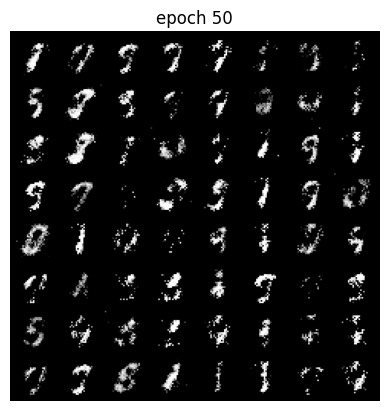

Epoch 50 of 200
Generator loss: 0.81552733, Discriminator loss: 0.17310829


118it [00:15,  7.68it/s]                         


Epoch 51 of 200
Generator loss: 0.82892458, Discriminator loss: 0.16150678


118it [00:15,  7.67it/s]                         


Epoch 52 of 200
Generator loss: 0.83206526, Discriminator loss: 0.13761791


118it [00:15,  7.49it/s]                         


Epoch 53 of 200
Generator loss: 0.82945804, Discriminator loss: 0.15902444


118it [00:16,  7.37it/s]                         


Epoch 54 of 200
Generator loss: 0.83997812, Discriminator loss: 0.14913085


118it [00:15,  7.47it/s]                         


Epoch 55 of 200
Generator loss: 0.83198046, Discriminator loss: 0.15837695


118it [00:15,  7.63it/s]                         


Epoch 56 of 200
Generator loss: 0.82454266, Discriminator loss: 0.15978292


118it [00:15,  7.80it/s]                         


Epoch 57 of 200
Generator loss: 0.83578330, Discriminator loss: 0.14531859


118it [00:15,  7.69it/s]                         


Epoch 58 of 200
Generator loss: 0.81172419, Discriminator loss: 0.16348200


118it [00:15,  7.59it/s]                         


Epoch 59 of 200
Generator loss: 0.80528755, Discriminator loss: 0.17766632


118it [00:15,  7.69it/s]                         


Epoch 60 of 200
Generator loss: 0.79539502, Discriminator loss: 0.18441719


118it [00:15,  7.64it/s]                         


Epoch 61 of 200
Generator loss: 0.77121435, Discriminator loss: 0.20096295


118it [00:15,  7.55it/s]                         


Epoch 62 of 200
Generator loss: 0.77605914, Discriminator loss: 0.19815975


118it [00:15,  7.50it/s]                         


Epoch 63 of 200
Generator loss: 0.75665825, Discriminator loss: 0.20149616


118it [00:15,  7.56it/s]                         


Epoch 64 of 200
Generator loss: 0.76037936, Discriminator loss: 0.21316940


118it [00:15,  7.77it/s]                         


Epoch 65 of 200
Generator loss: 0.72476610, Discriminator loss: 0.22504662


118it [00:15,  7.75it/s]                         


Epoch 66 of 200
Generator loss: 0.69162340, Discriminator loss: 0.25054890


118it [00:15,  7.67it/s]                         


Epoch 67 of 200
Generator loss: 0.72786806, Discriminator loss: 0.21565453


118it [00:15,  7.66it/s]                         


Epoch 68 of 200
Generator loss: 0.73077863, Discriminator loss: 0.21410254


118it [00:15,  7.69it/s]                         


Epoch 69 of 200
Generator loss: 0.76557091, Discriminator loss: 0.18868016


118it [00:15,  7.70it/s]                         


Epoch 70 of 200
Generator loss: 0.76120472, Discriminator loss: 0.18251273


118it [00:15,  7.61it/s]                         


Epoch 71 of 200
Generator loss: 0.76092378, Discriminator loss: 0.19000364


118it [00:15,  7.44it/s]                         


Epoch 72 of 200
Generator loss: 0.72805494, Discriminator loss: 0.22309302


118it [00:15,  7.59it/s]                         


Epoch 73 of 200
Generator loss: 0.71537144, Discriminator loss: 0.23439705


118it [00:15,  7.60it/s]                         


Epoch 74 of 200
Generator loss: 0.71192047, Discriminator loss: 0.23306677


118it [00:15,  7.70it/s]                         


Epoch 75 of 200
Generator loss: 0.70163411, Discriminator loss: 0.24362107


118it [00:15,  7.63it/s]                         


Epoch 76 of 200
Generator loss: 0.73044878, Discriminator loss: 0.22524755


118it [00:15,  7.64it/s]                         


Epoch 77 of 200
Generator loss: 0.72173632, Discriminator loss: 0.22049053


118it [00:15,  7.72it/s]                         


Epoch 78 of 200
Generator loss: 0.70501118, Discriminator loss: 0.23004734


118it [00:15,  7.71it/s]                         


Epoch 79 of 200
Generator loss: 0.69898694, Discriminator loss: 0.24453141


118it [00:15,  7.49it/s]                         


Epoch 80 of 200
Generator loss: 0.73169876, Discriminator loss: 0.21323850


118it [00:16,  7.32it/s]                         


Epoch 81 of 200
Generator loss: 0.73550579, Discriminator loss: 0.21506861


118it [00:15,  7.57it/s]                         


Epoch 82 of 200
Generator loss: 0.72335188, Discriminator loss: 0.21976818


118it [00:15,  7.63it/s]                         


Epoch 83 of 200
Generator loss: 0.71228306, Discriminator loss: 0.22304675


118it [00:15,  7.67it/s]                         


Epoch 84 of 200
Generator loss: 0.70745809, Discriminator loss: 0.23238803


118it [00:15,  7.65it/s]                         


Epoch 85 of 200
Generator loss: 0.71136749, Discriminator loss: 0.22233899


118it [00:15,  7.68it/s]                         


Epoch 86 of 200
Generator loss: 0.68392408, Discriminator loss: 0.24896176


118it [00:15,  7.63it/s]                         


Epoch 87 of 200
Generator loss: 0.67760420, Discriminator loss: 0.24922433


118it [00:15,  7.60it/s]                         


Epoch 88 of 200
Generator loss: 0.66476086, Discriminator loss: 0.25587325


118it [00:15,  7.39it/s]                         


Epoch 89 of 200
Generator loss: 0.67796690, Discriminator loss: 0.24843182


118it [00:15,  7.50it/s]                         


Epoch 90 of 200
Generator loss: 0.68584924, Discriminator loss: 0.24648937


118it [00:15,  7.60it/s]                         


Epoch 91 of 200
Generator loss: 0.64758120, Discriminator loss: 0.26414759


118it [00:15,  7.72it/s]                         


Epoch 92 of 200
Generator loss: 0.65645753, Discriminator loss: 0.26540222


118it [00:15,  7.64it/s]                         


Epoch 93 of 200
Generator loss: 0.65538706, Discriminator loss: 0.26289236


118it [00:15,  7.66it/s]                         


Epoch 94 of 200
Generator loss: 0.61459381, Discriminator loss: 0.29972069


118it [00:15,  7.68it/s]                         


Epoch 95 of 200
Generator loss: 0.63202842, Discriminator loss: 0.28023824


118it [00:15,  7.62it/s]                         


Epoch 96 of 200
Generator loss: 0.65323206, Discriminator loss: 0.26541384


118it [00:15,  7.57it/s]                         


Epoch 97 of 200
Generator loss: 0.64428710, Discriminator loss: 0.26212275


118it [00:16,  7.31it/s]                         


Epoch 98 of 200
Generator loss: 0.65921087, Discriminator loss: 0.25440231


118it [00:15,  7.44it/s]                         


Epoch 99 of 200
Generator loss: 0.64614526, Discriminator loss: 0.26584220


118it [00:15,  7.65it/s]                         


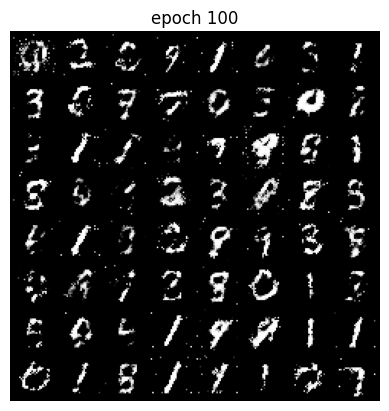

Epoch 100 of 200
Generator loss: 0.64532743, Discriminator loss: 0.26822850


118it [00:15,  7.66it/s]                         


Epoch 101 of 200
Generator loss: 0.64796429, Discriminator loss: 0.26528444


118it [00:15,  7.64it/s]                         


Epoch 102 of 200
Generator loss: 0.64521740, Discriminator loss: 0.26866307


118it [00:15,  7.61it/s]                         


Epoch 103 of 200
Generator loss: 0.61391910, Discriminator loss: 0.28807031


118it [00:15,  7.62it/s]                         


Epoch 104 of 200
Generator loss: 0.60405345, Discriminator loss: 0.29100380


118it [00:15,  7.63it/s]                         


Epoch 105 of 200
Generator loss: 0.61631793, Discriminator loss: 0.29966335


118it [00:15,  7.44it/s]                         


Epoch 106 of 200
Generator loss: 0.58605553, Discriminator loss: 0.30537765


118it [00:15,  7.50it/s]                         


Epoch 107 of 200
Generator loss: 0.60630094, Discriminator loss: 0.29008406


118it [00:15,  7.66it/s]                         


Epoch 108 of 200
Generator loss: 0.61922780, Discriminator loss: 0.28527597


118it [00:15,  7.68it/s]                         


Epoch 109 of 200
Generator loss: 0.61111024, Discriminator loss: 0.28957915


118it [00:15,  7.59it/s]                         


Epoch 110 of 200
Generator loss: 0.60070316, Discriminator loss: 0.29985012


118it [00:15,  7.72it/s]                         


Epoch 111 of 200
Generator loss: 0.59932905, Discriminator loss: 0.29439510


118it [00:15,  7.66it/s]                         


Epoch 112 of 200
Generator loss: 0.60198926, Discriminator loss: 0.29798820


118it [00:15,  7.57it/s]                         


Epoch 113 of 200
Generator loss: 0.61770905, Discriminator loss: 0.28533028


118it [00:15,  7.54it/s]                         


Epoch 114 of 200
Generator loss: 0.59439552, Discriminator loss: 0.30145205


118it [00:15,  7.41it/s]                         


Epoch 115 of 200
Generator loss: 0.60208791, Discriminator loss: 0.29446015


118it [00:15,  7.51it/s]                         


Epoch 116 of 200
Generator loss: 0.59406187, Discriminator loss: 0.29701595


118it [00:15,  7.64it/s]                         


Epoch 117 of 200
Generator loss: 0.60033267, Discriminator loss: 0.29723818


118it [00:15,  7.58it/s]                         


Epoch 118 of 200
Generator loss: 0.61576304, Discriminator loss: 0.28105407


118it [00:15,  7.73it/s]                         


Epoch 119 of 200
Generator loss: 0.57633980, Discriminator loss: 0.30552522


118it [00:15,  7.68it/s]                         


Epoch 120 of 200
Generator loss: 0.60157748, Discriminator loss: 0.29414514


118it [00:15,  7.69it/s]                         


Epoch 121 of 200
Generator loss: 0.60390077, Discriminator loss: 0.29151584


118it [00:15,  7.67it/s]                         


Epoch 122 of 200
Generator loss: 0.59811668, Discriminator loss: 0.29405207


118it [00:15,  7.50it/s]                         


Epoch 123 of 200
Generator loss: 0.58922754, Discriminator loss: 0.29908469


118it [00:16,  7.36it/s]                         


Epoch 124 of 200
Generator loss: 0.59948777, Discriminator loss: 0.30583091


118it [00:15,  7.64it/s]                         


Epoch 125 of 200
Generator loss: 0.55409230, Discriminator loss: 0.32793646


118it [00:15,  7.63it/s]                         


Epoch 126 of 200
Generator loss: 0.56643437, Discriminator loss: 0.31780331


118it [00:15,  7.67it/s]                         


Epoch 127 of 200
Generator loss: 0.56422335, Discriminator loss: 0.30925839


118it [00:15,  7.78it/s]                         


Epoch 128 of 200
Generator loss: 0.57739545, Discriminator loss: 0.30990607


118it [00:15,  7.64it/s]                         


Epoch 129 of 200
Generator loss: 0.57834301, Discriminator loss: 0.31759227


118it [00:15,  7.72it/s]                         


Epoch 130 of 200
Generator loss: 0.54039886, Discriminator loss: 0.33291682


118it [00:15,  7.56it/s]                         


Epoch 131 of 200
Generator loss: 0.55791846, Discriminator loss: 0.31201456


118it [00:15,  7.48it/s]                         


Epoch 132 of 200
Generator loss: 0.56237344, Discriminator loss: 0.31409240


118it [00:15,  7.47it/s]                         


Epoch 133 of 200
Generator loss: 0.56229893, Discriminator loss: 0.31945505


118it [00:15,  7.57it/s]                         


Epoch 134 of 200
Generator loss: 0.56691014, Discriminator loss: 0.32107767


118it [00:15,  7.64it/s]                         


Epoch 135 of 200
Generator loss: 0.52402394, Discriminator loss: 0.34140281


118it [00:15,  7.74it/s]                         


Epoch 136 of 200
Generator loss: 0.54661561, Discriminator loss: 0.32218089


118it [00:15,  7.67it/s]                         


Epoch 137 of 200
Generator loss: 0.55333484, Discriminator loss: 0.32513938


118it [00:15,  7.61it/s]                         


Epoch 138 of 200
Generator loss: 0.54942602, Discriminator loss: 0.32955147


118it [00:15,  7.66it/s]                         


Epoch 139 of 200
Generator loss: 0.53490547, Discriminator loss: 0.33114865


118it [00:15,  7.72it/s]                         


Epoch 140 of 200
Generator loss: 0.53115423, Discriminator loss: 0.33658766


118it [00:15,  7.49it/s]                         


Epoch 141 of 200
Generator loss: 0.53900662, Discriminator loss: 0.33085321


118it [00:15,  7.39it/s]                         


Epoch 142 of 200
Generator loss: 0.52761787, Discriminator loss: 0.34108662


118it [00:15,  7.52it/s]                         


Epoch 143 of 200
Generator loss: 0.52966657, Discriminator loss: 0.33618833


118it [00:15,  7.62it/s]                         


Epoch 144 of 200
Generator loss: 0.54435834, Discriminator loss: 0.32677517


118it [00:15,  7.52it/s]                         


Epoch 145 of 200
Generator loss: 0.52881066, Discriminator loss: 0.33844843


118it [00:15,  7.67it/s]                         


Epoch 146 of 200
Generator loss: 0.53669226, Discriminator loss: 0.33832333


118it [00:15,  7.58it/s]                         


Epoch 147 of 200
Generator loss: 0.53365659, Discriminator loss: 0.33436787


118it [00:15,  7.63it/s]                         


Epoch 148 of 200
Generator loss: 0.53018421, Discriminator loss: 0.33870161


118it [00:15,  7.44it/s]                         


Epoch 149 of 200
Generator loss: 0.52285910, Discriminator loss: 0.34336289


118it [00:16,  7.35it/s]                         


Epoch 150 of 200
Generator loss: 0.51693795, Discriminator loss: 0.34317791


118it [00:15,  7.48it/s]                         


Epoch 151 of 200
Generator loss: 0.51645192, Discriminator loss: 0.34394731


118it [00:15,  7.61it/s]                         


Epoch 152 of 200
Generator loss: 0.52554364, Discriminator loss: 0.34125317


118it [00:15,  7.59it/s]                         


Epoch 153 of 200
Generator loss: 0.53793907, Discriminator loss: 0.33196610


118it [00:15,  7.54it/s]                         


Epoch 154 of 200
Generator loss: 0.51960260, Discriminator loss: 0.34433297


118it [00:15,  7.53it/s]                         


Epoch 155 of 200
Generator loss: 0.51439786, Discriminator loss: 0.34342399


118it [00:15,  7.55it/s]                         


Epoch 156 of 200
Generator loss: 0.50845902, Discriminator loss: 0.34521151


118it [00:15,  7.54it/s]                         


Epoch 157 of 200
Generator loss: 0.51127398, Discriminator loss: 0.35128734


118it [00:16,  7.33it/s]                         


Epoch 158 of 200
Generator loss: 0.50198099, Discriminator loss: 0.35315029


118it [00:15,  7.39it/s]                         


Epoch 159 of 200
Generator loss: 0.51374244, Discriminator loss: 0.34978560


118it [00:15,  7.53it/s]                         


Epoch 160 of 200
Generator loss: 0.51563958, Discriminator loss: 0.35292226


118it [00:15,  7.53it/s]                         


Epoch 161 of 200
Generator loss: 0.49719827, Discriminator loss: 0.35478721


118it [00:15,  7.68it/s]                         


Epoch 162 of 200
Generator loss: 0.51004500, Discriminator loss: 0.34689814


118it [00:15,  7.69it/s]                         


Epoch 163 of 200
Generator loss: 0.50970882, Discriminator loss: 0.35088306


118it [00:15,  7.69it/s]                         


Epoch 164 of 200
Generator loss: 0.50087951, Discriminator loss: 0.35853085


118it [00:15,  7.60it/s]                         


Epoch 165 of 200
Generator loss: 0.50049426, Discriminator loss: 0.35644645


118it [00:15,  7.44it/s]                         


Epoch 166 of 200
Generator loss: 0.51069482, Discriminator loss: 0.35337405


118it [00:16,  7.37it/s]                         


Epoch 167 of 200
Generator loss: 0.49580873, Discriminator loss: 0.35989547


118it [00:15,  7.43it/s]                         


Epoch 168 of 200
Generator loss: 0.48622233, Discriminator loss: 0.36182444


118it [00:15,  7.66it/s]                         


Epoch 169 of 200
Generator loss: 0.49585382, Discriminator loss: 0.35638921


118it [00:15,  7.53it/s]                         


Epoch 170 of 200
Generator loss: 0.50080608, Discriminator loss: 0.35485643


118it [00:15,  7.54it/s]                         


Epoch 171 of 200
Generator loss: 0.49482921, Discriminator loss: 0.36531538


118it [00:15,  7.55it/s]                         


Epoch 172 of 200
Generator loss: 0.48761859, Discriminator loss: 0.36387182


118it [00:15,  7.59it/s]                         


Epoch 173 of 200
Generator loss: 0.47914378, Discriminator loss: 0.37024420


118it [00:15,  7.53it/s]                         


Epoch 174 of 200
Generator loss: 0.49362125, Discriminator loss: 0.35840891


118it [00:16,  7.31it/s]                         


Epoch 175 of 200
Generator loss: 0.48816553, Discriminator loss: 0.36992209


118it [00:16,  7.36it/s]                         


Epoch 176 of 200
Generator loss: 0.47705944, Discriminator loss: 0.36962517


118it [00:15,  7.46it/s]                         


Epoch 177 of 200
Generator loss: 0.49591017, Discriminator loss: 0.36342217


118it [00:15,  7.49it/s]                         


Epoch 178 of 200
Generator loss: 0.49614476, Discriminator loss: 0.36362051


118it [00:15,  7.56it/s]                         


Epoch 179 of 200
Generator loss: 0.48746486, Discriminator loss: 0.36544742


118it [00:15,  7.53it/s]                         


Epoch 180 of 200
Generator loss: 0.49000652, Discriminator loss: 0.36027140


118it [00:15,  7.52it/s]                         


Epoch 181 of 200
Generator loss: 0.48719342, Discriminator loss: 0.36280288


118it [00:15,  7.45it/s]                         


Epoch 182 of 200
Generator loss: 0.47619692, Discriminator loss: 0.37053518


118it [00:15,  7.38it/s]                         


Epoch 183 of 200
Generator loss: 0.46684372, Discriminator loss: 0.38216346


118it [00:15,  7.53it/s]                         


Epoch 184 of 200
Generator loss: 0.45517165, Discriminator loss: 0.39321704


118it [00:15,  7.62it/s]                         


Epoch 185 of 200
Generator loss: 0.44750748, Discriminator loss: 0.38405202


118it [00:15,  7.63it/s]                         


Epoch 186 of 200
Generator loss: 0.47618829, Discriminator loss: 0.36893012


118it [00:15,  7.63it/s]                         


Epoch 187 of 200
Generator loss: 0.48772122, Discriminator loss: 0.36921944


118it [00:15,  7.50it/s]                         


Epoch 188 of 200
Generator loss: 0.47579421, Discriminator loss: 0.37434923


118it [00:15,  7.63it/s]                         


Epoch 189 of 200
Generator loss: 0.46198438, Discriminator loss: 0.38098491


118it [00:15,  7.68it/s]                         


Epoch 190 of 200
Generator loss: 0.47321078, Discriminator loss: 0.36783743


118it [00:16,  7.33it/s]                         


Epoch 191 of 200
Generator loss: 0.47791624, Discriminator loss: 0.36226445


118it [00:16,  7.35it/s]                         


Epoch 192 of 200
Generator loss: 0.47820948, Discriminator loss: 0.37527744


118it [00:15,  7.60it/s]                         


Epoch 193 of 200
Generator loss: 0.46173144, Discriminator loss: 0.37684536


118it [00:15,  7.62it/s]                         


Epoch 194 of 200
Generator loss: 0.46224753, Discriminator loss: 0.37662680


118it [00:15,  7.50it/s]                         


Epoch 195 of 200
Generator loss: 0.46275146, Discriminator loss: 0.37751308


118it [00:15,  7.59it/s]                         


Epoch 196 of 200
Generator loss: 0.46909473, Discriminator loss: 0.37625212


118it [00:15,  7.60it/s]                         


Epoch 197 of 200
Generator loss: 0.44443233, Discriminator loss: 0.38783892


118it [00:15,  7.60it/s]                         


Epoch 198 of 200
Generator loss: 0.47133861, Discriminator loss: 0.37541927


118it [00:15,  7.43it/s]                         


Epoch 199 of 200
Generator loss: 0.46565943, Discriminator loss: 0.37941724


118it [00:16,  7.31it/s]                         


Epoch 200 of 200
Generator loss: 0.44548777, Discriminator loss: 0.39096089
DONE TRAINING


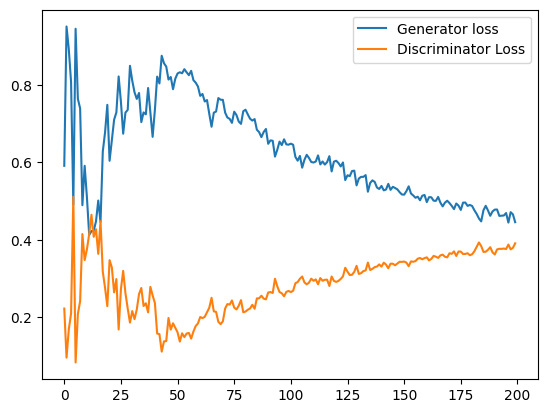

In [ ]:
# Question 1c:
# Improvements - LSGAN, Label smoothing for Discriminator, smoothing decay

def gen_loss_c(output, true_label):
    criterion = nn.MSELoss()
    return criterion(output[:,0], true_label[:,0])

def dis_loss_c(output, true_label, completion_ratio = 1.0):
    criterion = nn.MSELoss()
    if completion_ratio < 0.5:
        smooth = torch.rand(true_label.size(0)).to(device)
        true_label = true_label + (1 - completion_ratio*2)*(0.2*smooth - 0.1)
    return criterion(output[:,0], true_label[:,0])

test_gan('1c', discriminator_loss=dis_loss_c, generator_loss=gen_loss_c, enableGANHacks=True)

118it [00:15,  7.53it/s]                         


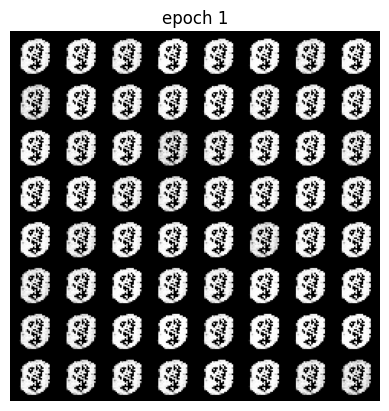

Epoch 1 of 100
Generator loss: 0.33284405, Discriminator loss: -13.24924745


118it [00:15,  7.60it/s]                         


Epoch 2 of 100
Generator loss: -28.12208695, Discriminator loss: -28.85221667


118it [00:15,  7.54it/s]                         


Epoch 3 of 100
Generator loss: -59.88250183, Discriminator loss: -45.34381299


118it [00:16,  7.03it/s]                         


Epoch 4 of 100
Generator loss: -26.14227761, Discriminator loss: -1.69144060


118it [00:17,  6.79it/s]


Epoch 5 of 100
Generator loss: -25.19469090, Discriminator loss: -63.01924327


118it [00:17,  6.92it/s]                         


Epoch 6 of 100
Generator loss: 74.47647214, Discriminator loss: -188.59728593


118it [00:16,  7.05it/s]                         


Epoch 7 of 100
Generator loss: 177.75972598, Discriminator loss: -364.37480672


118it [00:15,  7.60it/s]                         


Epoch 8 of 100
Generator loss: 168.79756256, Discriminator loss: -355.12872419


118it [00:15,  7.75it/s]                         


Epoch 9 of 100
Generator loss: -112.48160161, Discriminator loss: -51.87109114


118it [00:15,  7.74it/s]                         


Epoch 10 of 100
Generator loss: -96.52292196, Discriminator loss: -33.04383328


118it [00:15,  7.57it/s]                         


Epoch 11 of 100
Generator loss: -53.26104055, Discriminator loss: -59.76339738


118it [00:15,  7.67it/s]                         


Epoch 12 of 100
Generator loss: -25.24018509, Discriminator loss: -66.21476139


118it [00:15,  7.64it/s]                         


Epoch 13 of 100
Generator loss: -9.90253091, Discriminator loss: -70.23702181


118it [00:15,  7.71it/s]                         


Epoch 14 of 100
Generator loss: -6.49883949, Discriminator loss: -73.54508770


118it [00:15,  7.70it/s]                         


Epoch 15 of 100
Generator loss: -4.67539210, Discriminator loss: -75.48818768


118it [00:15,  7.56it/s]                         


Epoch 16 of 100
Generator loss: -2.60191786, Discriminator loss: -76.29694040


118it [00:15,  7.47it/s]                         


Epoch 17 of 100
Generator loss: 12.60357614, Discriminator loss: -90.45278194


118it [00:15,  7.61it/s]                         


Epoch 18 of 100
Generator loss: 68.07092450, Discriminator loss: -166.99832903


118it [00:15,  7.61it/s]                         


Epoch 19 of 100
Generator loss: 115.40498782, Discriminator loss: -275.74672379


118it [00:15,  7.69it/s]                         


Epoch 20 of 100
Generator loss: 135.31490737, Discriminator loss: -332.86626284


118it [00:15,  7.64it/s]                         


Epoch 21 of 100
Generator loss: 138.03721997, Discriminator loss: -343.95989677


118it [00:15,  7.67it/s]                         


Epoch 22 of 100
Generator loss: 139.73735738, Discriminator loss: -348.11435458


118it [00:15,  7.68it/s]                         


Epoch 23 of 100
Generator loss: 139.70484103, Discriminator loss: -348.56195538


118it [00:15,  7.63it/s]                         


Epoch 24 of 100
Generator loss: 140.10285206, Discriminator loss: -349.06339101


118it [00:15,  7.41it/s]                         


Epoch 25 of 100
Generator loss: 30.95167207, Discriminator loss: -239.49949659


118it [00:16,  7.35it/s]                         


Epoch 26 of 100
Generator loss: -123.41859319, Discriminator loss: -9.29150665


118it [00:15,  7.52it/s]                         


Epoch 27 of 100
Generator loss: -64.21515111, Discriminator loss: -61.58600982


118it [00:15,  7.60it/s]                         


Epoch 28 of 100
Generator loss: -49.17410970, Discriminator loss: -57.83600747


118it [00:16,  7.37it/s]                         


Epoch 29 of 100
Generator loss: -94.76836275, Discriminator loss: -10.58223098


118it [00:15,  7.46it/s]                         


Epoch 30 of 100
Generator loss: -117.67586501, Discriminator loss: -55.21434145


118it [00:15,  7.68it/s]                         


Epoch 31 of 100
Generator loss: -111.86808255, Discriminator loss: 5.98439111


118it [00:15,  7.61it/s]                         


Epoch 32 of 100
Generator loss: -84.46806003, Discriminator loss: -0.47422354


118it [00:15,  7.68it/s]                         


Epoch 33 of 100
Generator loss: -82.61686250, Discriminator loss: -2.90618981


118it [00:15,  7.45it/s]                         


Epoch 34 of 100
Generator loss: -42.16008910, Discriminator loss: -28.62002906


118it [00:15,  7.54it/s]                         


Epoch 35 of 100
Generator loss: -14.32241759, Discriminator loss: -48.17128268


118it [00:15,  7.48it/s]                         


Epoch 36 of 100
Generator loss: -6.67654159, Discriminator loss: -66.96789955


118it [00:15,  7.78it/s]                         


Epoch 37 of 100
Generator loss: -3.83520910, Discriminator loss: -70.65300242


118it [00:15,  7.73it/s]                         


Epoch 38 of 100
Generator loss: -3.35031318, Discriminator loss: -70.89513919


118it [00:15,  7.72it/s]                         


Epoch 39 of 100
Generator loss: -2.49702193, Discriminator loss: -72.04772988


118it [00:15,  7.66it/s]                         


Epoch 40 of 100
Generator loss: -1.94910363, Discriminator loss: -72.55318079


118it [00:15,  7.49it/s]                         


Epoch 41 of 100
Generator loss: -1.33910021, Discriminator loss: -72.65906486


118it [00:15,  7.72it/s]                         


Epoch 42 of 100
Generator loss: -0.96472006, Discriminator loss: -72.70631259


118it [00:15,  7.55it/s]                         


Epoch 43 of 100
Generator loss: 5.20967475, Discriminator loss: -75.82518925


118it [00:15,  7.48it/s]                         


Epoch 44 of 100
Generator loss: 60.84546689, Discriminator loss: -117.76237051


118it [00:15,  7.66it/s]                         


Epoch 45 of 100
Generator loss: 82.02092208, Discriminator loss: -131.00214640


118it [00:15,  7.70it/s]                         


Epoch 46 of 100
Generator loss: 84.25993217, Discriminator loss: -131.44557405


118it [00:15,  7.72it/s]                         


Epoch 47 of 100
Generator loss: 84.74278598, Discriminator loss: -131.94630119


118it [00:15,  7.60it/s]                         


Epoch 48 of 100
Generator loss: 84.80549472, Discriminator loss: -131.95132414


118it [00:15,  7.68it/s]                         


Epoch 49 of 100
Generator loss: 76.88136706, Discriminator loss: -125.50267505


118it [00:15,  7.56it/s]                         


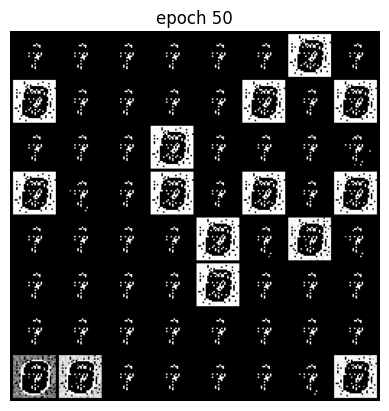

Epoch 50 of 100
Generator loss: 11.33879071, Discriminator loss: -121.42311566


118it [00:15,  7.56it/s]                         


Epoch 51 of 100
Generator loss: 55.01120148, Discriminator loss: -117.07907359


118it [00:15,  7.43it/s]                         


Epoch 52 of 100
Generator loss: 67.71873412, Discriminator loss: -129.95427071


118it [00:15,  7.42it/s]                         


Epoch 53 of 100
Generator loss: -34.05058117, Discriminator loss: -65.09453527


118it [00:16,  7.31it/s]                         


Epoch 54 of 100
Generator loss: -156.06279135, Discriminator loss: -30.91585769


118it [00:16,  6.99it/s]                         


Epoch 55 of 100
Generator loss: -57.62268283, Discriminator loss: 10.18013625


118it [00:15,  7.60it/s]                         


Epoch 56 of 100
Generator loss: 32.37185813, Discriminator loss: -30.80227666


118it [00:15,  7.50it/s]                         


Epoch 57 of 100
Generator loss: 16.00981522, Discriminator loss: -50.22703394


118it [00:15,  7.54it/s]                         


Epoch 58 of 100
Generator loss: -27.51201017, Discriminator loss: -43.62413631


118it [00:15,  7.60it/s]                         


Epoch 59 of 100
Generator loss: -26.87901889, Discriminator loss: -48.86661683


118it [00:15,  7.62it/s]                         


Epoch 60 of 100
Generator loss: 77.02008373, Discriminator loss: -152.27350147


118it [00:15,  7.60it/s]                         


Epoch 61 of 100
Generator loss: 92.63899681, Discriminator loss: -174.02010352


118it [00:15,  7.38it/s]                         


Epoch 62 of 100
Generator loss: 92.85104872, Discriminator loss: -174.84410878


118it [00:15,  7.40it/s]                         


Epoch 63 of 100
Generator loss: 92.99242760, Discriminator loss: -175.08642617


118it [00:16,  7.33it/s]                         


Epoch 64 of 100
Generator loss: 93.08690878, Discriminator loss: -175.25173207


118it [00:15,  7.65it/s]                         


Epoch 65 of 100
Generator loss: 93.15573185, Discriminator loss: -175.26075810


118it [00:15,  7.64it/s]                         


Epoch 66 of 100
Generator loss: 93.14129886, Discriminator loss: -175.29110574


118it [00:15,  7.58it/s]                         


Epoch 67 of 100
Generator loss: 93.16879592, Discriminator loss: -175.31286621


118it [00:15,  7.63it/s]                         


Epoch 68 of 100
Generator loss: 93.20909621, Discriminator loss: -175.27600424


118it [00:15,  7.45it/s]                         


Epoch 69 of 100
Generator loss: 93.25588076, Discriminator loss: -175.26133376


118it [00:15,  7.48it/s]                         


Epoch 70 of 100
Generator loss: 93.21812628, Discriminator loss: -175.27861153


118it [00:16,  7.23it/s]                         


Epoch 71 of 100
Generator loss: 93.22753365, Discriminator loss: -175.30836878


118it [00:15,  7.46it/s]                         


Epoch 72 of 100
Generator loss: 93.25477150, Discriminator loss: -175.33229756


118it [00:15,  7.45it/s]                         


Epoch 73 of 100
Generator loss: 93.19781696, Discriminator loss: -175.33365638


118it [00:15,  7.50it/s]                         


Epoch 74 of 100
Generator loss: 93.27122374, Discriminator loss: -175.28259656


118it [00:15,  7.62it/s]                         


Epoch 75 of 100
Generator loss: 93.08897687, Discriminator loss: -175.38780786


118it [00:15,  7.62it/s]                         


Epoch 76 of 100
Generator loss: 93.24271419, Discriminator loss: -175.29469273


118it [00:15,  7.58it/s]                         


Epoch 77 of 100
Generator loss: 93.16683484, Discriminator loss: -175.33463516


118it [00:15,  7.56it/s]                         


Epoch 78 of 100
Generator loss: 93.19996500, Discriminator loss: -175.30898318


118it [00:16,  7.25it/s]                         


Epoch 79 of 100
Generator loss: 93.16703562, Discriminator loss: -175.33583395


118it [00:16,  7.32it/s]                         


Epoch 80 of 100
Generator loss: 93.23254251, Discriminator loss: -175.38505698


118it [00:16,  6.99it/s]                         


Epoch 81 of 100
Generator loss: 93.25373586, Discriminator loss: -175.42066890


118it [00:15,  7.52it/s]                         


Epoch 82 of 100
Generator loss: 93.19378101, Discriminator loss: -175.37643511


118it [00:15,  7.56it/s]                         


Epoch 83 of 100
Generator loss: 93.24830693, Discriminator loss: -175.38741844


118it [00:15,  7.62it/s]                         


Epoch 84 of 100
Generator loss: 93.19611763, Discriminator loss: -175.28054470


118it [00:15,  7.60it/s]                         


Epoch 85 of 100
Generator loss: 93.21551318, Discriminator loss: -175.30409893


118it [00:15,  7.52it/s]                         


Epoch 86 of 100
Generator loss: 93.16723313, Discriminator loss: -175.33905460


118it [00:15,  7.60it/s]                         


Epoch 87 of 100
Generator loss: 93.22960435, Discriminator loss: -175.37258611


118it [00:15,  7.46it/s]                         


Epoch 88 of 100
Generator loss: 93.18953737, Discriminator loss: -175.26847970


118it [00:16,  7.31it/s]                         


Epoch 89 of 100
Generator loss: 93.18545597, Discriminator loss: -175.38325070


118it [00:15,  7.40it/s]                         


Epoch 90 of 100
Generator loss: 93.19976448, Discriminator loss: -175.26988233


118it [00:15,  7.60it/s]                         


Epoch 91 of 100
Generator loss: 93.18363190, Discriminator loss: -175.35662620


118it [00:15,  7.62it/s]                         


Epoch 92 of 100
Generator loss: 93.23178440, Discriminator loss: -175.31256599


118it [00:15,  7.60it/s]                         


Epoch 93 of 100
Generator loss: 93.18635683, Discriminator loss: -175.33524120


118it [00:15,  7.52it/s]                         


Epoch 94 of 100
Generator loss: 93.26649038, Discriminator loss: -175.32088412


118it [00:15,  7.61it/s]                         


Epoch 95 of 100
Generator loss: 93.21805273, Discriminator loss: -175.33977632


118it [00:15,  7.67it/s]                         


Epoch 96 of 100
Generator loss: 93.23774113, Discriminator loss: -175.28375140


118it [00:15,  7.41it/s]                         


Epoch 97 of 100
Generator loss: 93.21066988, Discriminator loss: -175.23052366


118it [00:16,  7.36it/s]                         


Epoch 98 of 100
Generator loss: 93.19905358, Discriminator loss: -175.36372232


118it [00:15,  7.52it/s]                         


Epoch 99 of 100
Generator loss: 93.23915165, Discriminator loss: -175.34569217


118it [00:15,  7.54it/s]                         


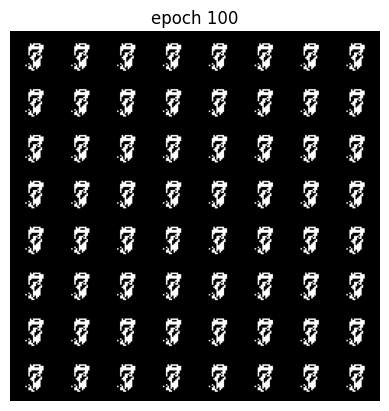

Epoch 100 of 100
Generator loss: 93.23489399, Discriminator loss: -175.29235683
DONE TRAINING


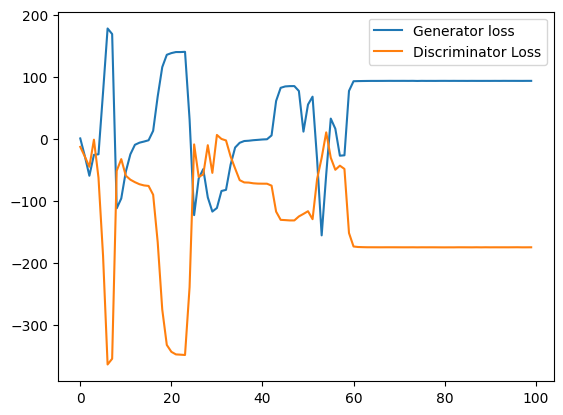

In [ ]:

# Wasserstein GAN test - Unsuccessful run

# def gen_loss_c(output, _true_label):
#     # Generator loss for Wasserstein GAN
#     # _true_label is always 1 -> No mapping needed
#     loss = -torch.mean(output)
#     return loss

# def dis_loss_c(output, true_label):
#     # Discriminator loss for Wasserstein GAN
#     lab = 2*true_label-1 # Mapping [0,1] -> [-1,1]
#     loss = -torch.mean(lab*output)
#     return loss

# test_gan('1c', discriminator_loss=dis_loss_c, generator_loss=gen_loss_c, isWasserstein=True)

In [ ]:
# Question 3:

import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree

# Data from the table
data = np.array([
    [1, 1, 1, 36],
    [1, 1, 0, 4],
    [1, 0, 1, 2],
    [1, 0, 0, 8],
    [0, 1, 1, 9],
    [0, 1, 0, 1],
    [0, 0, 1, 8],
    [0, 0, 0, 32],
])
data = np.repeat(data[:,:3], data[:,3], axis=0)

X = data[:, 0]
Y = data[:, 1]
Z = data[:, 2]

# calculate mutual information
def mutual_information(x, y):
    xy_counts = np.histogram2d(x, y, bins=2)[0]
    x_counts = np.histogram(x, bins=2)[0]
    y_counts = np.histogram(y, bins=2)[0]

    p_xy = xy_counts / np.sum(xy_counts)
    p_x = x_counts / np.sum(x_counts)
    p_y = y_counts / np.sum(y_counts)

    mi = np.sum(p_xy * np.log2(p_xy / (np.outer(p_x, p_y) + 1e-10)))
    return mi

# Calculate pair-wise mutual information
mi_XY = mutual_information(X, Y)
mi_XZ = mutual_information(X, Z)
mi_YZ = mutual_information(Y, Z)

print(f"Mutual Informations:\nI(X,Y) = {mi_XY}\nI(X,Z) = {mi_XZ}\nI(Y,Z) = {mi_YZ}")

# mutual information matrix
mi_matrix = np.array([
    [0, mi_XY, mi_XZ],
    [mi_XY, 0, mi_YZ],
    [mi_XZ, mi_YZ, 0],
    ])
nodes = ['X','Y','Z']

# Maximum weight tree via MST of negative matrix
mst = minimum_spanning_tree(-mi_matrix)
edges = np.vstack(mst.nonzero()).T

print("Edges of the Chow-Liu algorithm tree:")
for edge in edges:
    print(f"{nodes[edge[0]]}-{nodes[edge[1]]}")


Mutual Informations:
I(X,Y) = 0.2780719045355597
I(X,Z) = 0.13284496123195416
I(Y,Z) = 0.3973126091724085
Edges of the Chow-Liu algorithm tree:
X-Y
Y-Z
